In [1]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import gc
import json
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

hdc = Hdc(10_000, xp)

xp = numpy
mnist_recognition56.ipynb


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.58 μs


((10000, 7), (2000, 7))


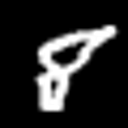
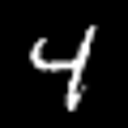
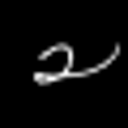
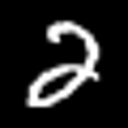
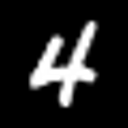
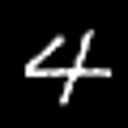
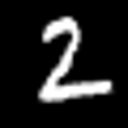
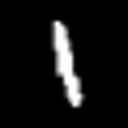
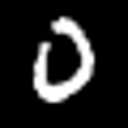
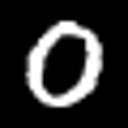
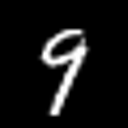
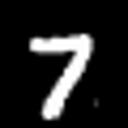
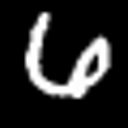
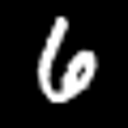
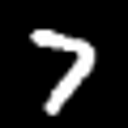
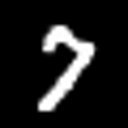

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [6]:
HP_SEQ_LV_COS_SIM_THRESHOLD = COS_SIM_45
HP_COMBI_SPACE_SIZE = 32
HP_SIGNAL_LEARN_OBSERVATIONS_COUNT_TRHES = 50
HP_SIGNAL_LEARN2_OBSERVATIONS_COUNT_TRHES = 50
HP_SIGNAL_PC_BINARIZE_THRES = 0.75
HP_SIGNAL_PCS_COUNT = 6

## Types

In [7]:
class SignalState(StrEnum):
    LEARN = auto()
    LEARN2 = auto()
    PROD = auto()

Signal = namedtuple('Signal', 
                    ['seq_lv_ind',
                     'image_id',
                     'value',
                     'seq_reading_code', 
                     'seq_reading',
                     'si_ind_dict',
                     'state',
                     'learn',
                     'learn2',
                     'prod'], defaults=[None, None, None])

SignalObservation = namedtuple('SignalObservation', 
                               ['image_id', 
                                'is_correct_match', 
                                'seq_reading_code', 
                                'seq_reading', 
                                'si_ind_dict'])

SignalLearnState = namedtuple('SignalLearnState', 
                              ['observations', 
                               # Output info
                               'pcs', 
                               'pc_ones_counts', 
                               'origin_offset'], defaults=[None, None, None])

SignalLearn2State = namedtuple('SignalLearn2State', 
                               ['observations', 
                                'pcs', 
                                'pc_ones_counts', 
                                'origin_offset', 
                                # Output info
                                'pc_sets', 
                                'pc_set_ones_counts', 
                                'pc_set_pc_inds_list'], defaults=[None, None, None])

SignalProdState = namedtuple('SignalProdState', ['origin_offset', 'pc_sets', 'pc_set_ones_counts', 'pc_set_pc_inds_list'])

Matchee = namedtuple('Matchee', 
                     ['image_id',
                      'value',
                      'seq_lvs',
                      'seq_reading_codes', 
                      'sequences', 
                      'si_ind_dict'])

## Memory

In [8]:
SEQ_INGRESS_SUBLV_LEN = 150
SEQ_SEQ_SUBLV_LEN = 300
SEQ_SUBLV_LEN = SEQ_INGRESS_SUBLV_LEN + SEQ_SEQ_SUBLV_LEN
SEQ_SUBLVS_COUNT = 5
SEQ_LV_LEN = SEQ_SUBLV_LEN * SEQ_SUBLVS_COUNT

SEQ_LVS = HdvArray(SEQ_LV_LEN * 2, xp, dtype='f') # aka ligands
SIGNALS = {} # key - seq_lv_ind, value - Signal instance

MATCHEE_CACHE = {} # key - image_id, value - Matchee
CPAV_CACHE = {} # key - (image_id, seq_reading_code, origin_offset), value - corresponding combinatorial point activations vector (CPAV)

In [9]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory(with_caches=False):
    SEQ_LVS.clear()
    SIGNALS.clear()

    if with_caches:
        MATCHEE_CACHE.clear()
        CPAV_CACHE.clear()
    
    gc_memory()

## Combinatorial Space (CS)

In [10]:
CS_POINTS = []

patterns = [
    np.ones((5, 5), dtype='f'), # square
    np.ones((8, 3), dtype='f'), # horz bar (8x3)
    np.ones((3, 8), dtype='f'), # vert bar (3x8)
]
min_point_size = np.min(np.array(list(map(lambda p: p.shape, patterns))))
max_point_size = np.max(np.array(list(map(lambda p: p.shape, patterns))))
meshgrid = np.mgrid[0:HP_COMBI_SPACE_SIZE-min_point_size:2, 0:HP_COMBI_SPACE_SIZE-min_point_size:2]

for x, y in zip(meshgrid[1].ravel(), meshgrid[0].ravel()):
    for pattern in patterns:
        point = np.zeros((HP_COMBI_SPACE_SIZE + max_point_size, HP_COMBI_SPACE_SIZE + max_point_size), dtype='f')
        point[y:y+pattern.shape[0],x:x+pattern.shape[1]] = pattern
        point = point[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
        CS_POINTS.append(point.ravel())

CS_POINTS = xp.vstack(CS_POINTS)
CS_POINTS.shape

(675, 1024)

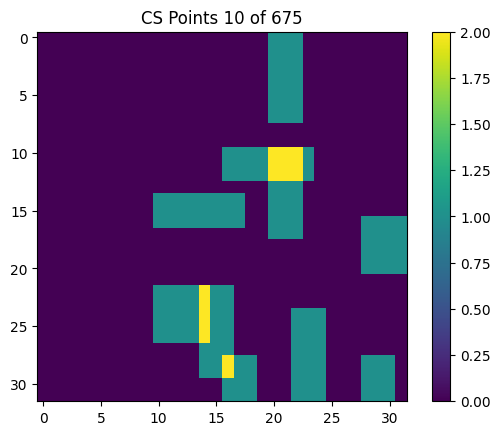

In [11]:
point_inds = RNG.choice(CS_POINTS.shape[0], 10, replace=False)
points_to_show = CS_POINTS[point_inds].sum(axis=0)
plt.imshow(points_to_show.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.title(f'CS Points {len(point_inds)} of {CS_POINTS.shape[0]}')
plt.colorbar()
plt.show()

In [12]:
CS_CLUSTERS = []

sz = HP_COMBI_SPACE_SIZE
probe_area_size = sz // 2
meshgrid = np.mgrid[0:sz-sz//4:sz//6,0:sz-sz//4:sz//6]

for x, y in zip(meshgrid[1].ravel(), meshgrid[0].ravel()):
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size, HP_COMBI_SPACE_SIZE + probe_area_size), dtype='f')
    probe_area[y:y+probe_area_size,x:x+probe_area_size] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

probe_area_size_h = sz
probe_area_size_v = sz // 4
meshgrid = np.mgrid[0:sz-sz//4:sz//6]

for y in meshgrid.ravel():
    x = 0
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size_v, HP_COMBI_SPACE_SIZE + probe_area_size_h), dtype='f')
    probe_area[y:y+probe_area_size_v,x:x+probe_area_size_h] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

probe_area_size_h = sz // 4
probe_area_size_v = sz
meshgrid = np.mgrid[0:sz-sz//4:sz//6]

for x in meshgrid.ravel():
    y = 0
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size_v, HP_COMBI_SPACE_SIZE + probe_area_size_h), dtype='f')
    probe_area[y:y+probe_area_size_v,x:x+probe_area_size_h] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

CS_CLUSTERS = xp.vstack(CS_CLUSTERS)
CS_CLUSTER_ONES_COUNTS = (CS_CLUSTERS > 0).sum(axis=1)
CS_CLUSTER_NUS = 1 / CS_CLUSTER_ONES_COUNTS
CS_CLUSTERS.shape, CS_CLUSTER_NUS.shape

((35, 675), (35,))

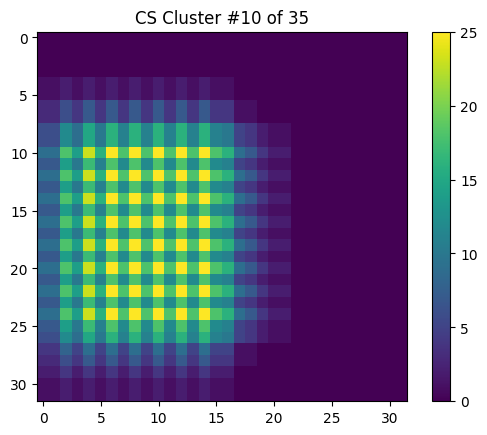

In [13]:
# cluster_ind = 1
cluster_ind = RNG.choice(len(CS_CLUSTERS))
cluster = CS_CLUSTERS[cluster_ind]
points_to_show = (CS_POINTS.T * cluster).T.sum(axis=0)
plt.imshow(points_to_show.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.title(f'CS Cluster #{cluster_ind} of {len(CS_CLUSTERS)}')
plt.colorbar()
plt.show()

## lambdas

In [14]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cs_point_activations_vec = lambda seq_bv: ((CS_POINTS @ seq_bv) > 0).astype('f')

## calc_seq_lv

In [15]:
def calc_seq_lv(sequences, si_ind_dict, seq_sublv_cache={}):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2), dtype='f')
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT, len(sequences)

    xy_prev_seq_tail = np.zeros(2)
    
    for sequence_i, (sequence, sublv) in enumerate(zip(sequences, seq_lv)):
        ingress_sublv = sublv[:SEQ_INGRESS_SUBLV_LEN]
        seq_sublv = sublv[SEQ_INGRESS_SUBLV_LEN:]
        
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        
        # 1) Ingress component of sublv, for very first sequence (sublv) there is no ingress 
        if sequence_i > 0:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            ingress_vec_len = int(np.round(np.linalg.norm(ingress_vec), decimals=0))
    
            if ingress_vec_len > 0:
                assert ingress_vec_len <= ingress_sublv.shape[0], ingress_vec_len
                ingress_sublv[:ingress_vec_len] = ingress_vec / ingress_vec_len
    
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last

        # 2) Seq component of sublv. 
        # At first check in cache - chances are that we've already done computation of seq_sublv.
        # Key for cache is starting si_ind. The bid here is that we have no duplicate si_ind within figure, 
        # as such each sub_lv is uniquely identified by starting si_ind
        starting_si_ind = sequence[0]

        if starting_si_ind in seq_sublv_cache:
            seq_sublv[:] = seq_sublv_cache[starting_si_ind]
        else:
            vec_sequence = np.roll(xy_sequence, -1, axis=0) - xy_sequence
            vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
            vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
            vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
            norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
            
            assert len(sequence) == vec_sequence.shape[0]
            assert len(sequence) == vec_len_sequence.shape[0]
            assert len(sequence) == norm_vec_sequence.shape[0]
            
            seq_len = vec_len_sequence.sum()
    
            if seq_len > 0:
                assert seq_len <= seq_sublv.shape[0], seq_len
                
                i = 0
                i_from = 0
                i_to = 0
        
                for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
                    if vec_len > 0:
                        i += vec_len
                        i_to = min(int(i), seq_sublv.shape[0])
                        assert i_from >= 0, i_from
                        assert i_to >= i_from, (i_to, i_from)
                        assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                        i_to2 = i_to
                        
                        if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                            i_to2 = seq_sublv.shape[0]
                
                        seq_sublv[i_from:i_to2] = norm_vec
                    
                    i_from = i_to
                
                    if i_to >= seq_sublv.shape[0]:
                        break
    
            seq_sublv_cache[starting_si_ind] = seq_sublv.copy() 
    
    return seq_lv.ravel()

## calc_seq_bv

In [16]:
def calc_seq_bv(seq_xy, origin_offset):
    seq_xy = xp_array_to_gpu(seq_xy - seq_xy[0] + origin_offset)
    seq_xy = seq_xy * (HP_COMBI_SPACE_SIZE / config.sample_size)
    # Leave only points which fit into square defined by HP_COMBI_CLUSTERS_SPACE_SIZE,
    # use filtering instead of clipping because clipping tends to introduce false point clustering at the bounadries
    seq_xy = xp.round(seq_xy, decimals=0)
    ii = xp.all(((seq_xy >= 0) & (seq_xy < HP_COMBI_SPACE_SIZE)), axis=1) 
    seq_xy = seq_xy[ii]
    ind_seq = (seq_xy @ xp.array([1, HP_COMBI_SPACE_SIZE])).astype(int)
    bitmap_vec = xp.zeros((HP_COMBI_SPACE_SIZE, HP_COMBI_SPACE_SIZE), dtype='f').ravel()
    bitmap_vec[ind_seq] = 1
    return bitmap_vec

## learn_signal_pcs

In [17]:
def learn_signal_pcs(signal):
    seq_xy = get_xy_sequence(get_sequence(signal.seq_reading), signal.si_ind_dict)
    center_xy = np.mean((seq_xy - seq_xy[0]), axis=0)
    origin_offset = -center_xy + np.full(2, config.sample_size / 2) # offset to move figure's center to center of future bitmap

    pcs_incubator = CS_CLUSTERS.copy()
    correct_obs = filter(lambda ob: ob.is_correct_match, signal.learn.observations.values())

    for ob in correct_obs:
        ob_seq_xy = get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict)
        ob_seq_bv = calc_seq_bv(ob_seq_xy, origin_offset)
        cpav = get_cs_point_activations_vec(ob_seq_bv)
        ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
        grow = (cpav * (CS_CLUSTER_NUS * ys)[:,np.newaxis]) # how weights of each PC must grow up, matrix, ca. shape (35, 675)
        grow *= CS_CLUSTERS # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
        nomins = pcs_incubator + grow # grow weights of incubated PCs
        denoms = nomins.max(axis=1) 
        pcs_incubator = (nomins.T / denoms).T # redistribute weights

    pcs = xp.where(pcs_incubator > HP_SIGNAL_PC_BINARIZE_THRES, 1, 0)
    pc_ones_counts = pcs.sum(axis=1).astype('f')
    return signal.learn._replace(pcs=pcs, pc_ones_counts=pc_ones_counts, origin_offset=origin_offset)

## learn_signal_pc_sets

In [18]:
def learn_signal_pc_sets(signal):
    # seq_xy -> seq_bv -> cpav -> pcs -> pc_sets
    observations = signal.learn2.observations
    pcs = signal.learn2.pcs
    pc_ones_counts = signal.learn2.pc_ones_counts
    origin_offset = signal.learn2.origin_offset
    
    # Calculate matrix: rows - true positive observations, columns - activation (0/1) of PC for observation
    correct_matches_flt = filter(lambda ob: ob.is_correct_match, observations.values())
    correct_matches_seq_xy = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), correct_matches_flt)
    correct_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), correct_matches_seq_xy))
    correct_bvs = xp.vstack(correct_bvs)
    correct_cpavs = ((correct_bvs @ CS_POINTS.T) > 0).astype('f') # how each seq_bv activated CP_POINTS, ca. shape (50, 675)
    correct_pc_activations_mat = (correct_cpavs @ pcs.T)
    correct_pc_activations_mat2 = (correct_pc_activations_mat >= pc_ones_counts).astype('f') # PC is activated when all its bits are ON
    correct_pc_activations_vec = correct_pc_activations_mat2.sum(axis=0) # vector, how many times each PC got activated

    # Construct PC_SETS - collection of most active PCs in all possible combinations (2^HP_SIGNAL_PCS_COUNT)
    top_active_pc_inds = xp.flip(xp.argsort(correct_pc_activations_vec)[-HP_SIGNAL_PCS_COUNT:])
    top_active_pc_inds = xp_array_from_gpu(top_active_pc_inds)
    
    pc_ind_combos = list(itertools.product([0, 1], repeat=HP_SIGNAL_PCS_COUNT)) # various combos in form of [0, 0, 1, 1, 0, 1]
    pc_ind_combos = np.array(pc_ind_combos[1:]) # take all combos except first degenerate one (it contains all zeros)
    pc_set_pc_inds_mat = np.where(pc_ind_combos, top_active_pc_inds, -1) # turn combo items 0/1 to corresponding indices of PCs e.g. [-1, -1, 17, 2, -1, 9]
    pc_sets = [] # PC_SET is a union of some other PCs
    pc_set_pc_inds_list = [] # inds of PCs which constitute given PC
    
    for pc_set_pc_inds in pc_set_pc_inds_mat:
        pc_set_pc_inds = pc_set_pc_inds[pc_set_pc_inds > -1]
        pc_set = np.max(pcs[pc_set_pc_inds], axis=0)
        assert np.array_equal(np.unique(pc_set), [0, 1])
        pc_sets.append(pc_set)
        pc_set_pc_inds_list.append(pc_set_pc_inds)
    
    pc_sets = xp.vstack(pc_sets)
    pc_set_ones_counts = pc_sets.sum(axis=1).astype('f')

    # Validate all observations (TP and FP) against PC_SETs
    confusion_matrix = np.zeros((pc_sets.shape[0], 2)) # column #0 - true positives, column #1 - false positives
    ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), observations.values())
    ob_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), ob_seq_xys))
    ob_bvs = xp.vstack(ob_bvs)
    ob_cpavs = ((ob_bvs @ CS_POINTS.T) > 0).astype('f')
    ob_pc_sets_activation_mat = (ob_cpavs @ pc_sets.T)
    ob_pc_sets_activation_mat = (ob_pc_sets_activation_mat >= pc_set_ones_counts).astype('f')
    
    for ob, ob_pc_sets_activation in zip(signal.learn.observations.values(), ob_pc_sets_activation_mat):
        confusion_matrix_col_index = 1 - int(ob.is_correct_match)
        confusion_matrix[:,confusion_matrix_col_index] += ob_pc_sets_activation

    # Retain only PC_SETs showed accuracy: some TP and no FP
    accurate_pc_set_inds = np.argwhere((confusion_matrix[:,1] == 0) & (confusion_matrix[:,0] > 1)).ravel()
    accurate_pc_sets = pc_sets[accurate_pc_set_inds]
    accurate_pc_set_ones_counts = pc_set_ones_counts[accurate_pc_set_inds]
    accurate_pc_set_inds_list = [pc_set_pc_inds_list[i] for i in accurate_pc_set_inds]
    return signal.learn2._replace(pc_sets=accurate_pc_sets, pc_set_ones_counts=accurate_pc_set_ones_counts, pc_set_pc_inds_list=accurate_pc_set_inds_list)

## memorize_signal

In [19]:
def memorize_signal(df_image):
    image_id = int(df_image.Index)
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    sequences = pickle.loads(df_image.inner_sequences)
    sequences = sequences[:SEQ_SUBLVS_COUNT] # TODO: cope somehow with more thatn SEQ_SUBLV_COUNT, e.g. generate several seq_lvs
    seq_reading_codes = [tuple(zip(range(len(sequences)), (0,) * len(sequences)))] # default reading
    seq_sublv_cache = {}
    
    for seq_reading_code in seq_reading_codes:
        seq_reading = get_sequences_reading(sequences, seq_reading_code)
        seq_lv = calc_seq_lv(seq_reading, si_ind_dict, seq_sublv_cache)
    
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv / np.linalg.norm(seq_lv))

        observation = SignalObservation(image_id=image_id,
                                        is_correct_match=True,
                                        seq_reading_code=seq_reading_code,
                                        seq_reading=seq_reading,
                                        si_ind_dict=si_ind_dict)
        learn = SignalLearnState(observations={image_id: observation})
        signal = Signal(seq_lv_ind=seq_lv_ind,
                        image_id=image_id,
                        value=df_image.value,
                        seq_reading_code=seq_reading_code, 
                        seq_reading=seq_reading,
                        si_ind_dict=si_ind_dict,
                        state=SignalState.LEARN,
                        learn=learn)
        assert not seq_lv_ind in SIGNALS
        SIGNALS[seq_lv_ind] = signal

    return signal

## create_matchee

In [20]:
def create_matchee(df_image, seq_reading_code=None):
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    sequences = pickle.loads(df_image.inner_sequences)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    seq_reading_codes = []

    if seq_reading_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                seq_reading_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        seq_reading_codes.append(seq_reading_code)

    seq_sublv_cache = {}
    seq_lvs = []
    
    for seq_reading_code in seq_reading_codes:
        seq_reading = get_sequences_reading(sequences, seq_reading_code)
        seq_lv = calc_seq_lv(seq_reading, si_ind_dict, seq_sublv_cache)
        seq_lvs.append(seq_lv)

    seq_lvs_norm = xp.array(seq_lvs)
    seq_lvs_norm = (seq_lvs_norm.T / xp.linalg.norm(seq_lvs_norm, axis=1)).T
    return Matchee(image_id=int(df_image.Index), 
                   value=df_image.value, 
                   seq_lvs=seq_lvs_norm, 
                   seq_reading_codes=seq_reading_codes, 
                   sequences=sequences, 
                   si_ind_dict=si_ind_dict)

## create_matchee_cached

In [21]:
def create_matchee_cached(df_image, seq_reading_code=None):
    image_id = int(df_image.Index)
    cache_key = (image_id, seq_reading_code)

    if not cache_key in MATCHEE_CACHE:
        MATCHEE_CACHE[cache_key] = create_matchee(df_image, seq_reading_code)

    return MATCHEE_CACHE[cache_key]    

## get_match_tab

In [22]:
def get_match_tab(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sims = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sims = np.flip(cos_sims)

    for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['cos_sim'].append(cos_sim)
        match_tab_columns['cos_sim_thres'].append(seq_lv_meta.cos_sim_thres)
        match_tab_columns['is_match'].append(cos_sim >= seq_lv_meta.cos_sim_thres)
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_seq_reading'].append(seq_lv_meta.seq_reading)
        match_tab_columns['engram_seq_lv_orig'].append(seq_lv_meta.seq_lv_orig)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['matchee_seq_reading'].append(matchee.seq_readings[j])
        match_tab_columns['matchee_seq_lv_orig'].append(matchee.seq_lvs_orig[j])

    return pd.DataFrame(match_tab_columns)

## render_match_tab_row

In [23]:
def render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy=0, k=None):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_reading = df_match_tab_row['matchee_seq_reading']
    matchee_seq_lv_ind = matchee.seq_readings.index(matchee_seq_reading)
    matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        offset = np.array([image_pil.size[0] // 2 + delta_xy, image_pil.size[1] // 2 + delta_xy])
        engram_xy_first = []
        matchee_xy_first = []

        for engram_seq_sublv, matchee_seq_sublv in zip(engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1), matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)):
            seq_sublv_offset = None
            
            for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_sublv.reshape(-1, 2), matchee_seq_sublv.reshape(-1, 2))):
                if serial == 0:
                    seq_sublv_offset = k * engram_xy + offset
                    continue

                assert not seq_sublv_offset is None
                engram_xy = k * engram_xy + seq_sublv_offset
                matchee_xy = k * matchee_xy + seq_sublv_offset
    
                if len(engram_xy_first) == 0:
                    engram_xy_first = engram_xy
    
                if len(matchee_xy_first) == 0:
                    matchee_xy_first = matchee_xy

                draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
                draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')
    
                if (serial % 10) == 0:
                    draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')

            draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k * 2, outline='red', width=3)
            draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k * 2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        engram_xy_first = []
        colors = ['red', 'orange']
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            # color = colors[si_serial % 2]
            color = 'red'
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])
            pt_from += delta_xy
            pt_to += delta_xy

            if len(engram_xy_first) == 0:
                engram_xy_first = k * pt_from
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        matchee_xy_first = []
        colors = ['green', 'cyan']
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            # color = colors[si_serial % 2]
            color = 'green'
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])
            pt_from += delta_xy
            pt_to += delta_xy

            if len(matchee_xy_first) == 0:
                matchee_xy_first = k * pt_from
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((matchee_xy_first[0], matchee_xy_first[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f} ({np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}), '
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

## .lab

# Train

In [24]:
LOG.is_enabled = True

In [48]:
train_images_count = min(1000, len(df_train_images))
max_learn_signals_count = 100

In [36]:
TRAIN_RUNS_COUNT = 0
TRAIN_IMAGES_COUNT = 0
# clear_memory(with_caches=False)
clear_memory(with_caches=True)

In [37]:
# learn_signal_pc_sets(SIGNALS[100])

In [72]:
# %%time
train_runs = 3

for train_run in tqdm(range(train_runs), desc='Train run'):
    with LOG.auto_prefix('TRRUN', train_run):
        TRAIN_RUNS_COUNT += 1
        
        train_image_ids = RNG.choice(df_train_images.index.unique(), train_images_count, replace=False)
        df_train_run_images = df_train_images.loc[train_image_ids]
        signals_by_state = Counter(map(lambda s: s.state.name, SIGNALS.values()))
        LOG(f'Signals 1): {signals_by_state}')
    
        ###
        for image in tqdm(df_train_run_images.itertuples(), total=len(df_train_run_images), leave=False, desc='Images'):
            image_id = int(image.Index)
            image_value = image.value
            
            with LOG.auto_prefix('IMGID', image_id, 'VAL', image_value):
                TRAIN_IMAGES_COUNT += 1
                
                matchee = create_matchee_cached(image)
        
                inspect_depth = 100
                cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
                top_mat_indices = xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:]
                cos_sims = xp.take(cos_sim_mat, top_mat_indices)
                top_mat_indices = xp_array_from_gpu(xp.flip(top_mat_indices))
                cos_sims = xp_array_from_gpu(xp.flip(cos_sims))
        
                is_learn_signal_exists = False
                matches = Counter()
                votes = {}
        
                for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
                    if cos_sim < HP_SEQ_LV_COS_SIM_THRESHOLD:
                        break
                    
                    seq_lv_ind = top_mat_index // cos_sim_mat.shape[1]
                    signal = SIGNALS[seq_lv_ind]
                    matchee_seq_lv_ind = top_mat_index % cos_sim_mat.shape[1]
                    matchee_seq_reading_code = matchee.seq_reading_codes[matchee_seq_lv_ind]
                    matchee_seq_reading = get_sequences_reading(matchee.sequences, matchee_seq_reading_code)
        
                    if signal.state in [SignalState.LEARN, SignalState.LEARN2]: 
                        is_learn_signal_exists = True
                        observation = SignalObservation(image_id=image_id, 
                                                        is_correct_match=(signal.value == image_value),
                                                        seq_reading_code=matchee_seq_reading_code,
                                                        seq_reading=matchee_seq_reading,
                                                        si_ind_dict=matchee.si_ind_dict)
                        observations_dict = signal.learn.observations if signal.state == SignalState.LEARN else signal.learn2.observations
                        observations_dict[image_id] = observation
                        continue

                    assert signal.state == SignalState.PROD, signal.state

                    matchee_seq_xy = get_xy_sequence(get_sequence(matchee_seq_reading), matchee.si_ind_dict)
                    matchee_seq_bv = calc_seq_bv(matchee_seq_xy, signal.prod.origin_offset)
                    cpav = get_cs_point_activations_vec(matchee_seq_bv)
                    pc_sets_activation_vec = (cpav @ signal.prod.pc_sets.T)
                    pc_sets_activation_vec = (pc_sets_activation_vec >= signal.prod.pc_set_ones_counts).astype('f')
                    is_match = np.any(pc_sets_activation_vec) # any of PC sets is activated?
        
                    if is_match and not signal.seq_lv_ind in votes:
                        votes[signal.seq_lv_ind] = signal.value
                        matches[signal.value] += 1
                        LOG(f'Prod signal seq_lv_ind={signal.seq_lv_ind} matched, value={signal.value}')

                if matches:
                    most_voted_value = matches.most_common(1)[0][0]
                    is_correct_match = (most_voted_value == image_value)
                    LOG(f'Matches: {matches}, most voted={most_voted_value}, is_correct_match={is_correct_match}')
                else:
                    is_correct_match = False
                    
                is_surprise = not is_learn_signal_exists and not is_correct_match
                learn_signals_count = signals_by_state[SignalState.LEARN.name] + signals_by_state[SignalState.LEARN2.name]
        
                if is_surprise and learn_signals_count < max_learn_signals_count:
                    signal = memorize_signal(image)
                    signals_by_state[SignalState.LEARN.name] += 1
                    LOG(f'New learn signal seq_lv_ind={signal.seq_lv_ind}. Learn signals {signals_by_state[SignalState.LEARN.name]} / {max_learn_signals_count}')
    
        ###
        signals_by_state = Counter(map(lambda s: s.state.name, SIGNALS.values()))
        LOG(f'Signals 2): {signals_by_state}')
        
        for signal in tqdm(SIGNALS.values(), leave=False, desc='Signals'):
            with LOG.auto_prefix('SIG', signal.seq_lv_ind, 'STATE', signal.state.name):
                if signal.state == SignalState.LEARN:
                    LOG(f'Signal has {len(signal.learn.observations)} observations, thres={HP_SIGNAL_LEARN_OBSERVATIONS_COUNT_TRHES}')
                    
                    if len(signal.learn.observations) < HP_SIGNAL_LEARN_OBSERVATIONS_COUNT_TRHES:
                       continue
    
                    learn = learn_signal_pcs(signal)
                    learn2 = SignalLearn2State(observations={}, pcs=learn.pcs, pc_ones_counts=learn.pc_ones_counts, origin_offset=learn.origin_offset)
                    SIGNALS[signal.seq_lv_ind] = signal._replace(state=SignalState.LEARN2, learn=learn, learn2=learn2)
                    LOG('PCs learned')
                elif signal.state == SignalState.LEARN2:
                    LOG(f'Signal has {len(signal.learn2.observations)} observations, thres={HP_SIGNAL_LEARN2_OBSERVATIONS_COUNT_TRHES}')

                    if len(signal.learn2.observations) < HP_SIGNAL_LEARN2_OBSERVATIONS_COUNT_TRHES:
                       continue
    
                    learn2 = learn_signal_pc_sets(signal)
                    prod = SignalProdState(origin_offset=learn.origin_offset, 
                                           pc_sets=learn2.pc_sets, 
                                           pc_set_ones_counts=learn2.pc_set_ones_counts, 
                                           pc_set_pc_inds_list=learn2.pc_set_pc_inds_list)
                    SIGNALS[signal.seq_lv_ind] = signal._replace(state=SignalState.PROD, learn2=learn2, prod=prod)
                    LOG('PC sets learned')

Train run:   0%|          | 0/3 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/300 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/300 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/300 [00:00<?, ?it/s]

In [44]:
list(reversed(sorted(map(lambda s: (len(s.learn.observations), s.seq_lv_ind), SIGNALS.values()))))[:20]

[(325, 13),
 (211, 34),
 (201, 4),
 (141, 30),
 (139, 11),
 (135, 17),
 (130, 28),
 (100, 15),
 (97, 7),
 (92, 65),
 (73, 39),
 (70, 75),
 (69, 12),
 (68, 78),
 (64, 63),
 (64, 38),
 (64, 23),
 (62, 22),
 (61, 46),
 (60, 2)]

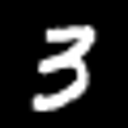

In [45]:
seq_lv_ind = 63
# seq_lv_ind = 64
get_raw_image(SIGNALS[seq_lv_ind].image_id)

In [41]:
# f = list(filter(lambda hi: hi.is_correct_match, SIGNALS[seq_lv_ind].learn.observations.values()))
# images = list(map(lambda hi: get_raw_image(hi.image_id), f))
# captions = list(map(lambda hi: str(hi.image_id), f))
# display_images_grid(images, captions=captions, col_count=5)

## 111

In [46]:
signal = SIGNALS[seq_lv_ind]

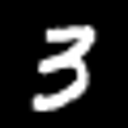

In [47]:
get_raw_image(signal.image_id)

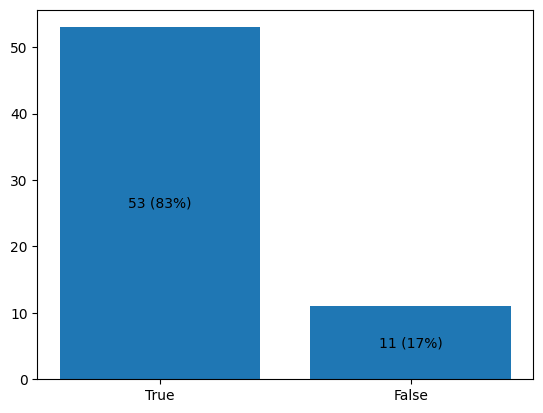

In [48]:
pos_neg = Counter(map(lambda ob: ob.is_correct_match, signal.learn.observations.values()))
b = plt.bar(list(map(str, pos_neg.keys())), list(pos_neg.values()))
plt.bar_label(b, map(lambda v: f'{v} ({100 * v / len(signal.learn.observations):.0f}%)', pos_neg.values()), label_type='center')
plt.show()

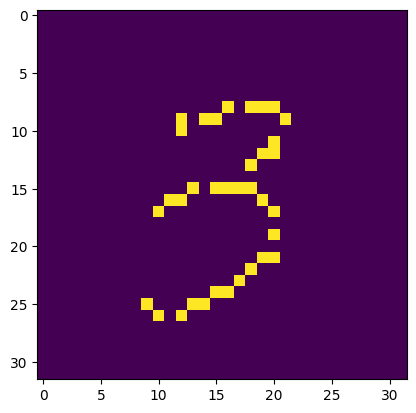

In [53]:
seq_xy = get_xy_sequence(get_sequence(signal.seq_reading), signal.si_ind_dict)
center_xy = np.mean((seq_xy - seq_xy[0]), axis=0)
origin_offset = -center_xy + np.full(2, config.sample_size / 2) # offset to move figure's center to center of future bitmap

bitmap_vec = calc_seq_bv(seq_xy, origin_offset)
plt.imshow(bitmap_vec.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.show()

In [56]:
pcs_incubator = CS_CLUSTERS.copy()

In [65]:
# %%time
hist_to_take = 999
correct_obs = list(filter(lambda hi: hi.is_correct_match, signal.learn.observations.values()))[:hist_to_take]
ob_seq_bvs = []
# z = (seq_pc_matur.seq_pc > 0).sum()
# nu = 1 / z
# print(z, nu)
# mask = (seq_pc > 0).astype('f')

# # nu = 0.0001
# processed = 0

for ob in correct_obs:
    ob_seq_xy = get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict)
    ob_seq_bv = calc_seq_bv(ob_seq_xy, origin_offset)
    ob_seq_bvs.append(ob_seq_bv)
    
    cpav = get_cs_point_activations_vec(ob_seq_bv)
    ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
    grow = (cpav * (CS_CLUSTER_NUS * ys)[:,np.newaxis]) # how weights of each PC must grow up, matrix, ca. shape (35, 675)
    grow *= CS_CLUSTERS # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
    nomins = pcs_incubator + grow # grow weights of incubated PCs
    denoms = nomins.max(axis=1) 
    pcs_incubator = (nomins.T / denoms).T # redistribute weights
    
    # nu = seq_pc_matur.nu[0]
    # seq_pc = seq_pc_matur.seq_pc
    # y = pcav @ seq_pc
    # grow = (pcav * (nu * y))
    # grow *= mask # masking (without masking 0 weights may get ressurected)
    # nomin = seq_pc + grow
    # denom = nomin.max()
    # seq_pc[:] = nomin / denom
    # # print(np.unique_counts(seq_pc_matur.seq_pc))
    # processed += 1

    # if thres < 0.85 and (zzz % 2) == 0 and False:
    #     seq_pc[:] = np.where(seq_pc >= thres, seq_pc, 0) # prune
    #     thres += 0.005
    #     print(f'{thres:.3f}, {(seq_pc > 0).sum()}')

# print(f'Processed: {processed}')
# zzz += 1

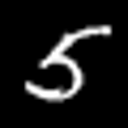

In [245]:
get_raw_image(f[8].image_id)

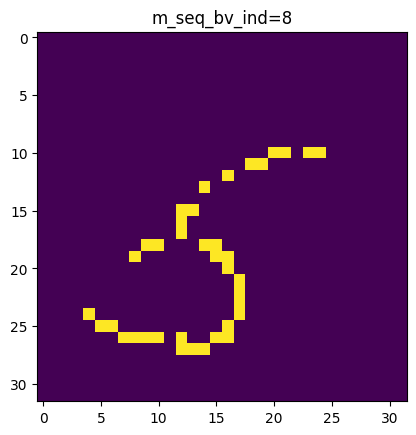

In [243]:
m_seq_bv_ind = RNG.choice(len(m_seq_bvs))
plt.imshow(m_seq_bvs[m_seq_bv_ind].reshape(HP_COMBI_CLUSTERS_SPACE_SIZE, -1))
plt.title(f'm_seq_bv_ind={m_seq_bv_ind}')
plt.show()

In [67]:
pcs = np.where(pcs_incubator > 0.75, 1, 0)

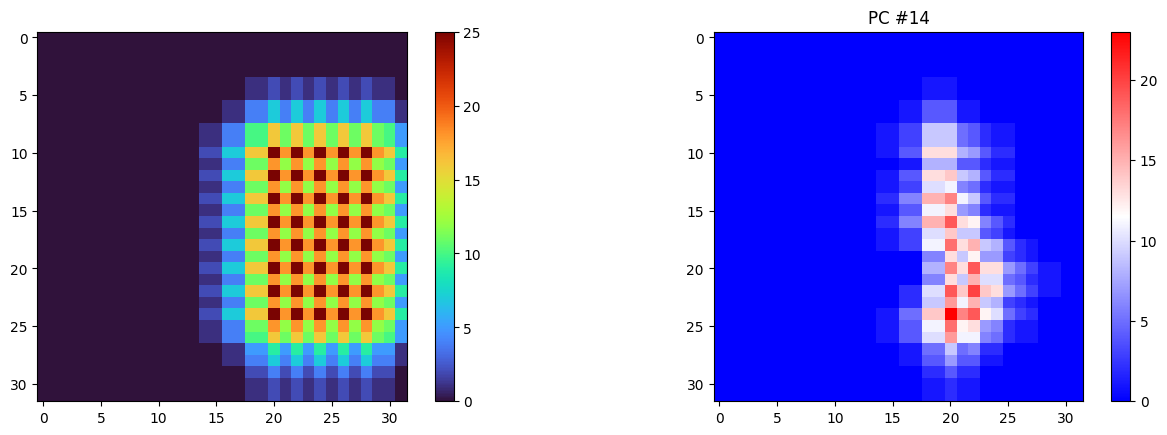

In [78]:
pc_ind = RNG.choice(pcs.shape[0])
# pc_ind = 6

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

cps1 = (CS_POINTS.T * CS_CLUSTERS[pc_ind]).T.sum(axis=0)
im = ax1.imshow(cps1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

cps2 = (CS_POINTS.T * pcs[pc_ind]).T.sum(axis=0)
im = ax2.imshow(cps2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.title(f'PC #{pc_ind}')
plt.show()

In [80]:
pc_ones_counts = pcs.sum(axis=1)

correct_matches_flt = list(filter(lambda ob: ob.is_correct_match, signal.learn.observations.values()))
correct_matches_cnt = len(correct_matches_flt)
correct_matches_seq_xy = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), correct_matches_flt)
correct_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), correct_matches_seq_xy))
correct_bvs = np.vstack(correct_bvs)
correct_cpavs = ((correct_bvs @ CS_POINTS.T) > 0).astype('f')
correct_pc_activations_mat = (correct_cpavs @ pcs.T)
correct_pc_activations_mat2 = (correct_pc_activations_mat >= pc_ones_counts).astype(int)
correct_pc_activations_vec = correct_pc_activations_mat2.sum(axis=0)
t = correct_pc_activations_vec
(t >= correct_matches_cnt).sum(), t, np.flip(np.sort(t)[-HP_SIGNAL_PCS_COUNT:])

(np.int64(0),
 array([12,  9,  9, 10, 13,  4,  1,  1,  1,  6,  4,  1,  1,  1,  4,  4,  1,
         1,  1,  7,  7,  3,  3,  3, 11, 21, 11,  6,  1,  3, 40, 15,  2,  1,
         3]),
 array([40, 21, 15, 13, 12, 11]))

In [145]:
np.unique(pc_set)

array([0, 1])

In [147]:
# seq_xy -> seq_bv -> cpav -> pcs -> pc_sets
top_active_pc_inds = xp.flip(xp.argsort(correct_pc_activations_vec)[-HP_SIGNAL_PCS_COUNT:])
top_active_pc_inds = xp_array_from_gpu(top_active_pc_inds)

pc_ind_combos = list(itertools.product([0, 1], repeat=HP_SIGNAL_PCS_COUNT)) # various combos in form of [0, 0, 1, 1, 0, 1]
pc_ind_combos = np.array(pc_ind_combos[1:]) # take all combos except first degenerate one (it contains all zeros)
pc_set_inds_mat = np.where(pc_ind_combos, top_active_pc_inds, -1) # turn combo items 0/1 to corresponding indices of PCs e.g. [-1, -1, 17, 2, -1, 9]
pc_sets = [] # PC_SET is a union of some other PCs
pc_set_inds_list = []

for pc_set_inds in pc_set_inds_mat:
    pc_set_inds = pc_set_inds[pc_set_inds > -1]
    pc_set = np.max(pcs[pc_set_inds], axis=0)
    assert np.array_equal(np.unique(pc_set), [0, 1])
    pc_sets.append(pc_set)
    pc_set_inds_list.append(pc_set_inds)

pc_sets = xp.vstack(pc_sets)
pc_set_ones_counts = pc_sets.sum(axis=1).astype('f')
pc_sets.shape

# pc_ind_combos = np.array(list(itertools.product([0, 1], repeat=HP_SIGNAL_PCS_COUNT))) # various combos in form of [0, 0, 1, 1, 0, 1]
# pc_set_inds_mat = np.where(pc_ind_combos, top_active_pc_inds, -1) # turn combo items 0/1 to indices e.g. [-1, -1, 3, 15, -1, 27]
# pc_set_masks = []

# for pc_set_inds in pc_set_inds_mat:
#     pc_set_inds = pc_set_inds[pc_set_inds > -1]
#     pc_set_mask = np.zeros(CS_CLUSTERS.shape[0], dtype='f')
#     pc_set_mask[pc_set_inds] = 1
#     pc_set_masks.append(pc_set_mask)

# pc_set_masks = xp.vstack(pc_set_masks)
# pc_set_masks.shape

(63, 675)

In [143]:
confusion_matrix = np.zeros((pc_sets.shape[0], 2), dtype='f')
ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.learn.observations.values())
ob_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), ob_seq_xys))
ob_bvs = np.vstack(ob_bvs)
ob_ccavs = ((ob_bvs @ CS_POINTS.T) > 0).astype('f')
ob_pc_sets_activation_mat = (ob_ccavs @ pc_sets.T)
ob_pc_sets_activation_mat = (ob_pc_sets_activation_mat >= pc_set_ones_counts).astype('f')

for ob, ob_pc_sets_activation in zip(signal.learn.observations.values(), ob_pc_sets_activation_mat):
    confusion_matrix_col_index = 1 - int(ob.is_correct_match)
    confusion_matrix[:,confusion_matrix_col_index] += ob_pc_sets_activation

# confusion_matrix = np.zeros((top_active_pc_set_masks.shape[0], 2))
# ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.learn.observations.values())
# ob_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), ob_seq_xys))
# ob_bvs = np.vstack(ob_bvs)
# ob_ccavs = ((ob_bvs @ CS_POINTS.T) > 0).astype('f')
# ob_pc_sets_activation_mat = (ob_ccavs @ pcs.T)
# ob_pc_sets_activation_mat = (ob_pc_sets_activation_mat >= pc_ones_counts).astype(int)

# for ob, ob_pc_sets_activation in zip(signal.learn.observations.values(), ob_pc_sets_activation_mat):
#     full_activation_vec = np.all((ob_pc_sets_activation * top_active_pc_set_masks) == top_active_pc_set_masks, axis=1).astype(int)
#     confusion_matrix_col_index = 1 - int(ob.is_correct_match)
#     confusion_matrix[:,confusion_matrix_col_index] += full_activation_vec

In [144]:
confusion_matrix[(confusion_matrix[:,1] == 0) & (confusion_matrix[:,0] > 1)]

array([[11.,  0.],
       [ 3.,  0.],
       [13.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [ 5.,  0.],
       [ 3.,  0.],
       [ 9.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [ 5.,  0.],
       [10.,  0.],
       [ 3.,  0.],
       [ 9.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [10.,  0.],
       [ 5.,  0.],
       [ 7.,  0.],
       [ 3.,  0.],
       [ 6.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [10.,  0.],
       [ 9.,  0.],
       [ 3.,  0.],
       [ 9.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [14.,  0.],
       [ 5.,  0.],
       [ 8.,  0.],
       [ 3.,  0.],
       [ 9.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [13.,  0.],
       [ 5.,  0.],
       [ 8.,  0.],
       [ 3.,  0.],
       [ 6.,  0.],
       [ 3.,  0.],
       [ 3.,  0.],
       [10.,  0.],
       [ 5.,  0.],
       [ 7.,  0.],
       [ 3.,  0.],
       [ 6.,  0.],
       [ 3.,  0.],
       [ 3.,  0.]], dtype=float32)

In [129]:
np.argwhere((confusion_matrix[:,1] == 0) & (confusion_matrix[:,0] > 1))

array([[ 0],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 8],
       [10],
       [11],
       [12],
       [13],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61]])

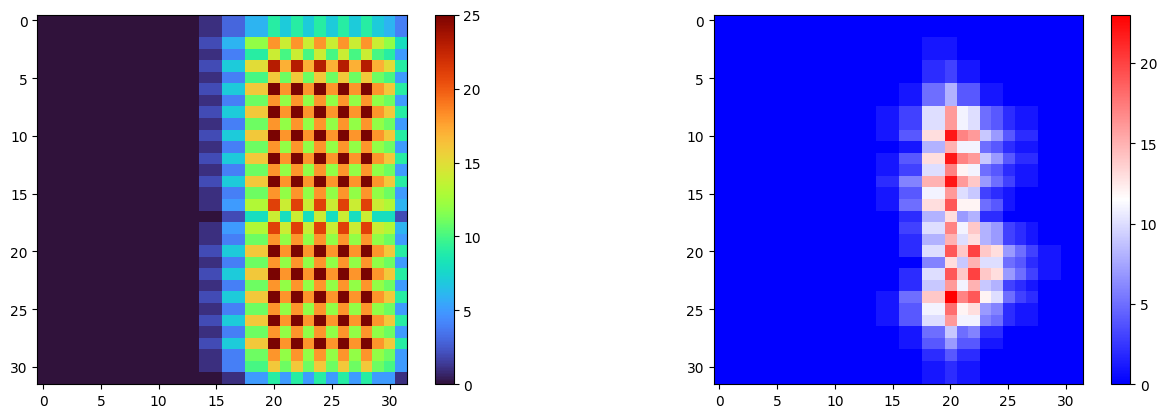

In [142]:
pc_set_ind = 4
pc_inds = pc_set_inds_list[pc_set_ind]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

map1 = (CS_POINTS.T * np.max(CS_CLUSTERS[pc_inds], axis=0)).T.sum(axis=0)
im = ax1.imshow(map1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

map2 = (CS_POINTS.T * pc_sets[pc_set_ind]).T.sum(axis=0)
im = ax2.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.show()

In [2179]:
%%time
t = (seq_pc_matur.seq_pc > 0)
seq_pc_bin = np.where(t, 1, 0)

wrong_matches_flt = list(filter(lambda hi: not hi.is_correct_match, signal.learn.observations.values()))
wrong_matches_cnt = len(wrong_matches_flt)
wrong_matches_seq_ipxys = map(lambda hi: calc_seq_ipxy_cached(hi.image_id, hi.seq_reading_code, hi.seq_reading, hi.si_ind_dict), wrong_matches_flt)
wrong_bvs = list(map(lambda ipxy: calc_seq_bv(ipxy, seq_lv_meta.maturing.origin_offset), wrong_matches_seq_ipxys))
wrong_bvs = np.vstack(wrong_bvs)
wrong_pcavs = ((wrong_bvs @ PC_CLUSTERS.T) > 0)
wrong_vec = (wrong_pcavs @ seq_pc_bin).T
#pc_ones_count = seq_pc_bin.sum()
pc_ones_count = np.max(wrong_vec) + 1

correct_matches_flt = list(filter(lambda hi: hi.is_correct_match, signal.learn.observations.values()))
correct_matches_cnt = len(correct_matches_flt)
correct_matches_seq_ipxys = map(lambda hi: calc_seq_ipxy_cached(hi.image_id, hi.seq_reading_code, hi.seq_reading, hi.si_ind_dict), correct_matches_flt)
correct_bvs = list(map(lambda ipxy: calc_seq_bv(ipxy, seq_lv_meta.maturing.origin_offset), correct_matches_seq_ipxys))
correct_bvs = np.vstack(correct_bvs)
correct_pcavs = ((correct_bvs @ PC_CLUSTERS.T) > 0)
correct_vec = (correct_pcavs @ seq_pc_bin).T

print(f'{pc_ones_count} / {t.sum()}')
print(f'Correct: {(correct_vec >= pc_ones_count).sum()} / {correct_matches_cnt}')
print(f'Wrong: {(wrong_vec >= pc_ones_count).sum()} / {wrong_matches_cnt}')

43 / 43
Correct: 0 / 109
Wrong: 0 / 51
CPU times: user 395 ms, sys: 0 ns, total: 395 ms
Wall time: 39 ms


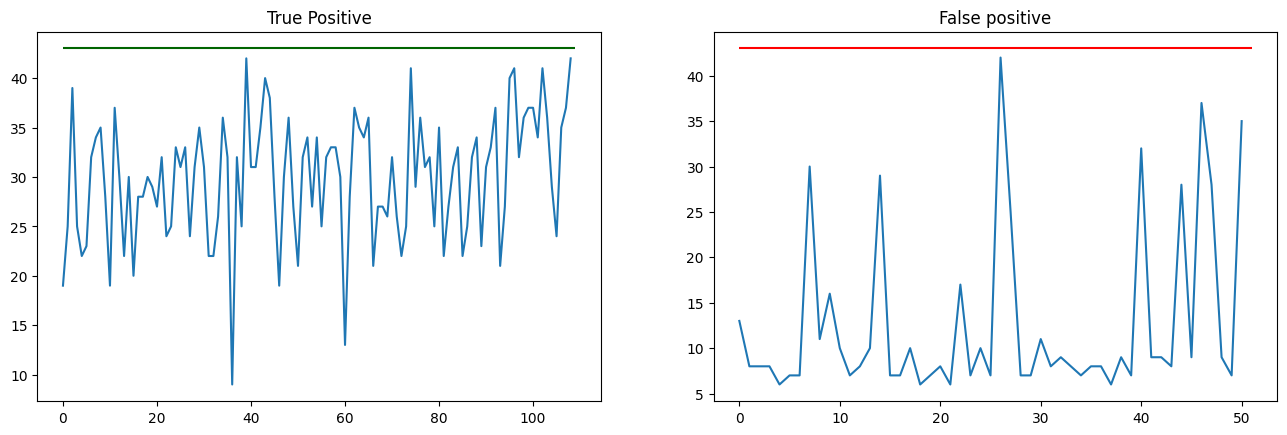

In [2180]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

ax1.plot(correct_vec)
ax1.hlines(pc_ones_count, 0, len(correct_vec), color='darkgreen')
ax1.set_title('True Positive')

ax2.plot(wrong_vec)
ax2.hlines(pc_ones_count, 0, len(wrong_vec), color='red')
ax2.set_title('False positive')

plt.show()

In [1263]:
correct_matches_flt = list(filter(lambda hi: hi.is_correct_match, seq_lv_meta.history.values()))
correct_matches_cnt = len(correct_matches_flt)
correct_matches_seq_ipxys = map(lambda hi: calc_seq_ipxy_cached(hi.image_id, hi.seq_reading_code, hi.seq_reading, hi.si_ind_dict), correct_matches_flt)
correct_bvs = list(map(lambda ipxy: calc_seq_bvs(ipxy, seq_lv_meta.maturing.origin_offset), correct_matches_seq_ipxys))
correct_bvs = np.vstack(correct_bvs)
correct_bvs.shape

(1150, 16384)

In [363]:
wrong_matches_flt = list(filter(lambda hi: not hi.is_correct_match, seq_lv_meta.history.values()))
wrong_matches_cnt = len(wrong_matches_flt)
wrong_matches_seq_ipxys = map(lambda hi: calc_seq_ipxy_cached(hi.image_id, hi.seq_reading_code, hi.seq_reading, hi.si_ind_dict), wrong_matches_flt)
wrong_bvs = list(map(lambda ipxy: calc_seq_bvs(ipxy, seq_lv_meta.maturing.origin_offset), wrong_matches_seq_ipxys))
wrong_bvs = np.vstack(wrong_bvs)
wrong_bvs.shape

(1125, 16384)

In [120]:
for thres in range(5, 100, 1):
    thres = thres / 100
    w = np.where(seq_pc_matur.seq_pc < thres, 0, 1) 
    dp = (correct_bvs @ w) # how many pixels in each correct_bvs is covered by w
    dp2 = dp >= np.sum(correct_bvs, axis=1)
    mat = dp2.reshape(correct_matches_cnt, -1)
    vec = np.any(mat > 0, axis=1)
    good_thres = np.all(vec)
    print(thres, good_thres)

    if not good_thres:
        break

0.05 True
0.06 True
0.07 True
0.08 True
0.09 True
0.1 True
0.11 True
0.12 True
0.13 True
0.14 True
0.15 True
0.16 True
0.17 True
0.18 True
0.19 True
0.2 True
0.21 False


In [364]:
for thres in range(5, 100, 1):
    thres = thres / 100
    w = np.where(seq_pc_matur.seq_pc < thres, 0, 1) 
    dp = (wrong_bvs @ w) # how many pixels in each wrong_bvs is covered by w
    dp2 = dp >= np.sum(wrong_bvs, axis=1)
    mat = dp2.reshape(wrong_matches_cnt, -1)
    vec = np.any(mat > 0, axis=1)
    good_thres = np.all(vec)
    print(thres, good_thres)

    if not good_thres:
        break

0.05 False


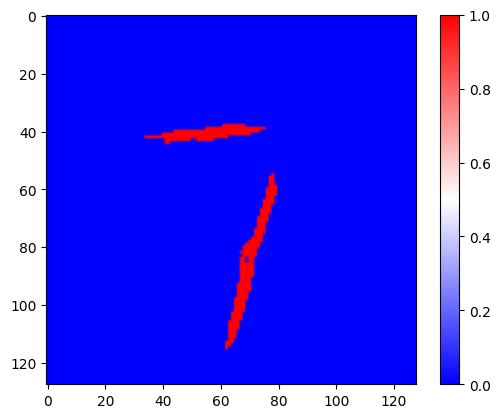

In [134]:
pc_comp_index = 0
pca1 = PCA(n_components = 5)
pca1.fit(correct_bvs)
pc = pca1.components_[pc_comp_index].reshape(config.sample_size, -1)
pc = np.where(pc < np.max(pc) * 0.5, 0, 1) # binarization
plt.imshow(pc, cmap='bwr')
plt.colorbar()
plt.show()

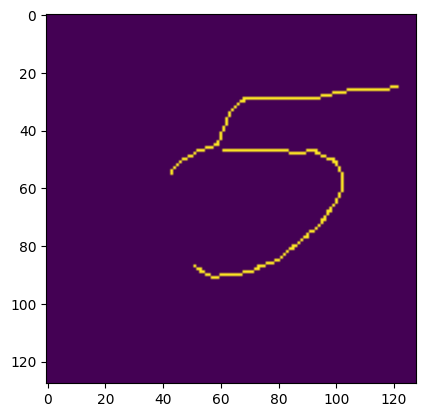

In [397]:
f = list(filter(lambda hi: hi.is_correct_match, SEQ_LV_METAS[seq_lv_ind].history.values()))
zz = list(map(lambda hi: (hi.image_id, hi.seq_reading_code), f))
zi = RNG.choice(len(zz))
z = zz[zi]

cache_key = (z[0], z[1])
seq_ipxy = SEQ_IPXY_CACHE[cache_key]
bvs = calc_seq_bvs(seq_ipxy, seq_lv_meta.maturing.origin_offset)
plt.imshow(bvs[0].reshape(config.sample_size, -1))
plt.show()

In [398]:
z

(28949, ((0, 0), (1, 0)))

In [399]:
# seq_ipxy

## .lab

In [252]:
list(reversed(sorted(map(lambda meta: (len(meta.history), meta.seq_lv_ind), SEQ_LV_IND_TO_META.values()))))[:10]

[(90, 68),
 (74, 231),
 (31, 1),
 (30, 243),
 (27, 20),
 (23, 200),
 (23, 172),
 (22, 48),
 (21, 217),
 (21, 65)]

In [259]:
seq_lv_ind = 243

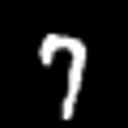

In [260]:
get_raw_image(ENGRAMS[SEQ_LV_IND_TO_META[seq_lv_ind].engram_id].image_id)

In [261]:
meta = SEQ_LV_IND_TO_META[seq_lv_ind]
image_seqs = [(meta.seq_reading, ENGRAMS[meta.engram_id].sequences, ENGRAMS[meta.engram_id].si_ind_dict)]
image_seqs.extend(map(lambda hi: (hi.seq_reading, hi.sequences, hi.si_ind_dict), filter(lambda hi: hi.is_correct_match, meta.history.values())))

In [281]:
np.arange(1)

array([0])

In [331]:
offsets = np.mgrid[-2:3, -2:3]

In [332]:
ofsets

array([[[-2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2]],

       [[-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2]]])

(array([-2, -2, -2, -2, -2, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2]),
 array([-2, -1,  0,  1,  2, -2, -1,  0,  1,  2, -2, -1,  0,  1,  2, -2, -1,
         0,  1,  2, -2, -1,  0,  1,  2]))

In [1071]:
a = RNG.normal(3, 10, (100, 2))
a[:,1] = RNG.normal(-2, 50, 100)

a_norm = StandardScaler().fit_transform(a)
# a2_norm = StandardScaler().fit_transform(a2[np.newaxis,:])

# a1.std(), a2.std(), a1_norm.std(), a2_norm.std()
a.mean(axis=0), a.std(axis=0), a_norm.mean(axis=0), a_norm.std(axis=0)

(array([  0.29306549, -11.31734911]),
 array([ 9.8051959 , 50.96681312]),
 array([3.99680289e-17, 1.33226763e-17]),
 array([1., 1.]))

In [1106]:
b = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
b = b - b.mean()
b, b / b.std()

(array([-0.2, -0.2, -0.2,  0.8, -0.2, -0.2,  0.8, -0.2, -0.2, -0.2]),
 array([-0.5, -0.5, -0.5,  2. , -0.5, -0.5,  2. , -0.5, -0.5, -0.5]))

In [1174]:
# %%time
bitmap_vecs = []
offsets = np.mgrid[-2:3, -2:3]
# offsets = np.mgrid[0:1, 0:1]

ФАК! Тут каждое прочтение начинается со своей координаты, а не с (0,0). В итоге
эффективность оффсетинга может быть ниже. Плюс из-за этого могут быть проблемы с 
формированием bitmap_vec - нарушение границ

# ПОПРОБОВАТЬ не хардкодед оффсеты, а на основе центра тяжести

for seq_reading, sequences, si_ind_dict in image_seqs:
    sequences_reading = get_sequences_reading(sequences, seq_reading)
    xy_seq_transcript = []  # Transcript with interpolation by xy
    
    for sequence_i, sequence in enumerate(sequences_reading):
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        vec_sequence = np.roll(xy_sequence, -1, axis=0) - xy_sequence
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        vec_len_sequence = vec_len_sequence.astype(int)
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        pt = xy_sequence[0]

        for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
            if vec_len == 0:
                continue
                
            pts = pt + (np.arange(vec_len) * norm_vec[np.newaxis,:].T).T # path interpolation
            xy_seq_transcript.append(pts.astype(int))
            pt = pts[-1]

    xy_seq_transcript = np.vstack(xy_seq_transcript)
    variant = 1

    match variant:
        case 1:
            # Регистрация оффсетов по отдельности
            for offset in zip(offsets[1].ravel(), offsets[0].ravel()):
                bitmap_vec = np.zeros((config.sample_size, config.sample_size), dtype='b').ravel()
                xy_seq_transcript_offs = xy_seq_transcript + offset
                ind_seq = xy_seq_transcript_offs @ np.array([1, config.sample_size])
                bitmap_vec[ind_seq] = 1
                bitmap_vecs.append(bitmap_vec)
        case 2:
            # Наложение оффсетов и объединение их в бандл
            bitmap_vec = np.zeros((config.sample_size, config.sample_size), dtype='b').ravel()
        
            for offset in zip(offsets[1].ravel(), offsets[0].ravel()):
                xy_seq_transcript_offs = xy_seq_transcript + offset
                ind_seq = xy_seq_transcript_offs @ np.array([1, config.sample_size])
                bitmap_vec[ind_seq] = 1
                
            bitmap_vecs.append(bitmap_vec)

bitmap_vecs = np.vstack(bitmap_vecs)
bitmap_vecs.shape

(750, 16384)

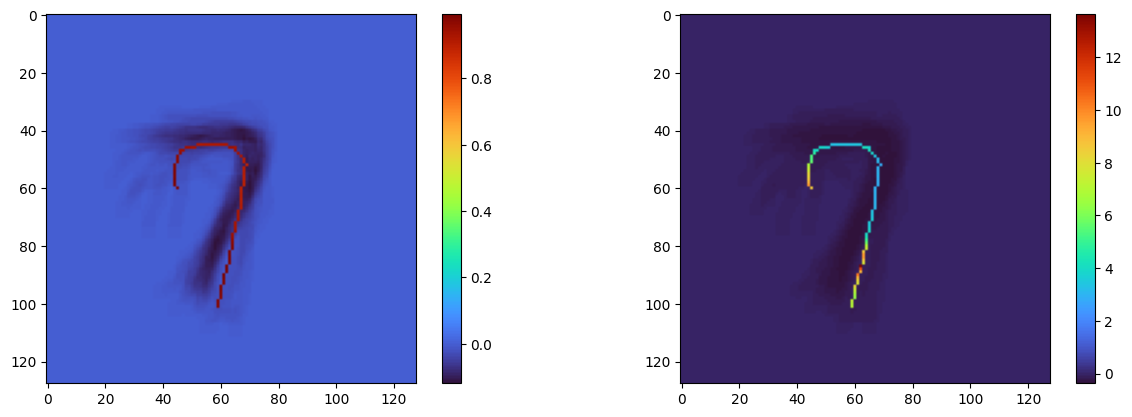

In [1175]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
bitmap_vecs_center = StandardScaler(with_std=False).fit_transform(bitmap_vecs)
bitmap_vecs_norm = StandardScaler().fit_transform(bitmap_vecs)

bitmap_vec_index = 0

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

im = ax1.imshow(bitmap_vecs_center[bitmap_vec_index].reshape(config.sample_size, -1), cmap='turbo')
ax1.figure.colorbar(im, ax=ax1)

im = ax2.imshow(bitmap_vecs_norm[bitmap_vec_index].reshape(config.sample_size, -1), cmap='turbo') 
ax2.figure.colorbar(im, ax=ax2)

plt.show()

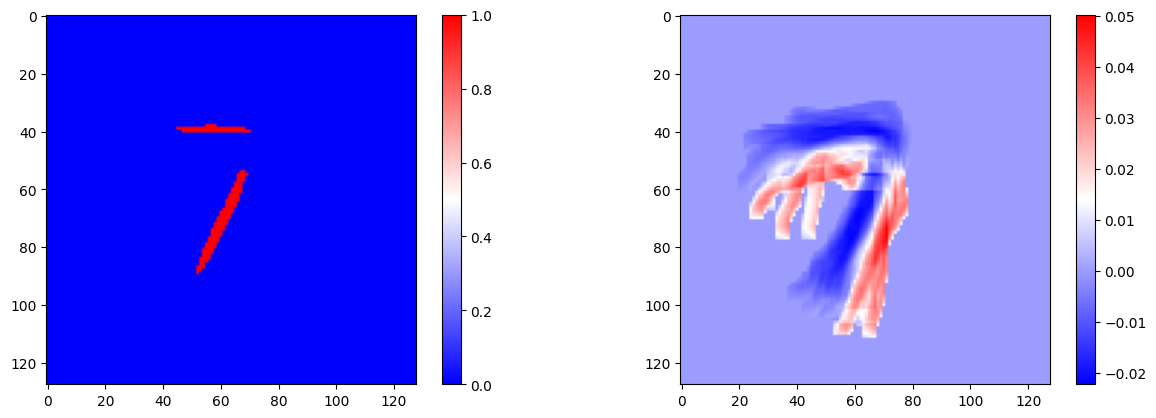

In [1277]:
pc_comp_index = 0

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

# Non-normalized PCA
pca1 = PCA(n_components = 5)
pca1.fit(bitmap_vecs)
pc = pca1.components_[pc_comp_index].reshape(config.sample_size, -1)
pc = np.where(pc < np.max(pc) * 0.5, 0, 1) # binarization
im = ax1.imshow(pc, cmap='bwr')
ax1.figure.colorbar(im, ax=ax1)

# # Normalized PCA
pca2 = PCA(n_components = 5)
pca2.fit(bitmap_vecs_norm)
im = ax2.imshow(pca2.components_[pc_comp_index].reshape(config.sample_size, -1), cmap='bwr') 
ax2.figure.colorbar(im, ax=ax2)

plt.show()

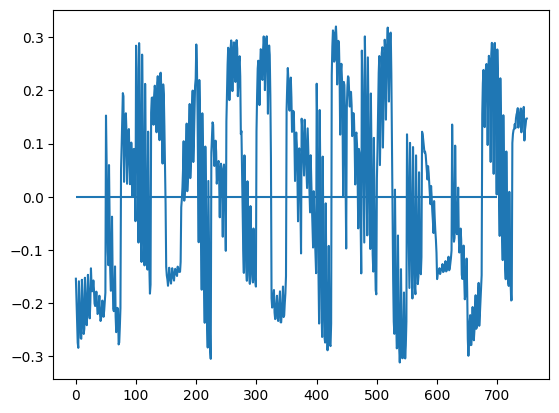

In [1180]:
cos_sims = pca1.components_[0] @ (bitmap_vecs_center.T / np.linalg.norm(bitmap_vecs_center, axis=1))
plt.plot(cos_sims)
plt.hlines(0, 0, 700)
# plt.hlines(0.5, 0, 700)
plt.show()

In [1195]:
np.argwhere(cos_sims <= 0)[100:110]

array([[164],
       [165],
       [166],
       [167],
       [168],
       [169],
       [170],
       [171],
       [172],
       [173]])

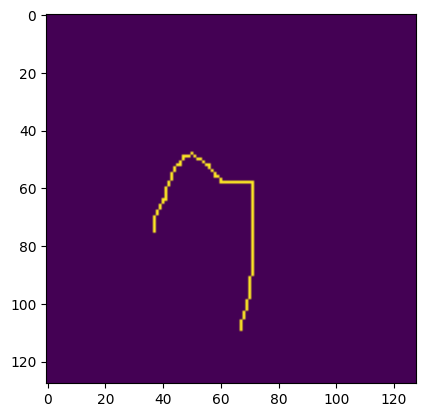

In [1196]:
plt.imshow(bitmap_vecs[164].reshape(config.sample_size, -1))
plt.show()

In [1184]:
np.argwhere(cos_sims > 0)[:10]

array([[50],
       [51],
       [55],
       [75],
       [76],
       [77],
       [78],
       [79],
       [80],
       [81]])

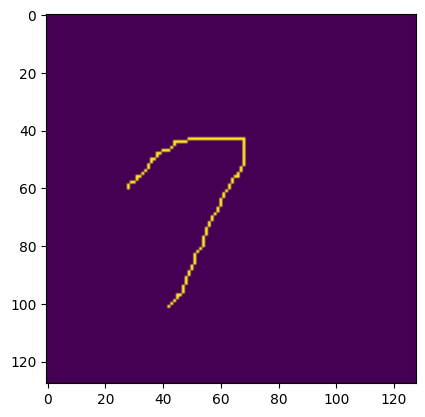

In [1188]:
plt.imshow(bitmap_vecs[80].reshape(config.sample_size, -1))
plt.show()

In [831]:
(bitmap_vecs.T / np.linalg.norm(bitmap_vecs, axis=1)).T @ pc

array([ 0.10992679,  0.13759479, -0.07370198, -0.01152136, -0.10206994,
       -0.08497602,  0.09200907, -0.07131005, -0.08930736, -0.08948215,
       -0.09799675, -0.07967004, -0.06966384,  0.05230102, -0.09128244,
       -0.05582559, -0.07239783, -0.0975324 , -0.09238823, -0.08621382,
       -0.06727956, -0.05665352, -0.06795289, -0.06658788,  0.94059388,
       -0.09400892,  0.01418852, -0.0618446 , -0.09270224, -0.09215248])

In [566]:
# np.argmax((bitmap_vecs.T / np.linalg.norm(bitmap_vecs, axis=1)).T @ pc), np.argmin((bitmap_vecs.T / np.linalg.norm(bitmap_vecs, axis=1)).T @ pc)

In [567]:
# np.max((bitmap_vecs.T / np.linalg.norm(bitmap_vecs, axis=1)).T @ pc), np.min((bitmap_vecs.T / np.linalg.norm(bitmap_vecs, axis=1)).T @ pc)

In [841]:
1 / bitmap_vecs[0].shape[0], 0.000001, 1 / bitmap_vecs[0].shape[0] - 0.000001

(6.103515625e-05, 1e-06, 6.003515625e-05)

In [1278]:
%%time
# weights = np.ones_like(bitmap_vecs[0], dtype='f')
# weights = np.full_like(bitmap_vecs[0], 0.001, dtype='f')
weights = np.full_like(bitmap_vecs[0], (1 / bitmap_vecs[0].shape[0]), dtype='f')
# nu = 0.1
# nu = 0.01
nu = 0.005
# method = 'oja' 
# method = 'classic' 
method = 'rdzb' 
# method = 'oja_2' 
# method = 'classic_2' 
# method = 'rdzb_2' 
batch_size = 100
processed_count = 0

for batch_i in range(len(bitmap_vecs) // batch_size + 1):
    bitmap_vecs_in_batch = bitmap_vecs[batch_i*batch_size:(batch_i+1) * batch_size]
    
    for bitmap_vec_i, bitmap_vec in enumerate(bitmap_vecs_in_batch):
        x = bitmap_vec
        y = x @ weights
    
        match method:
            case 'oja':
                # grow = (x * (nu * y))
                # stabil = nu * (y ** 2) * weights
                # weights = weights + grow - stabil
                # grow = (x * (nu * y))
                # stabil = nu * (y ** 2) * weights
                # weights = weights + grow - stabil
                
                # print(f'{processed_count + 1:2}, {nu:.2f}, {y:.2f}, {nu * y:.2f}')
                weights = weights + nu * y * (x - y * weights)
            case 'classic':
                # print(f'{processed_count + 1:2}, {nu:.2f}, {y:.2f}, {nu * y:.2f}')
                nomin = weights + (x * (nu * y))
                denom = np.sqrt(nomin @ nomin)
                weights = nomin / denom
            case 'rdzb':
                # print(f'{processed_count + 1:2}, {nu:.2f}, {y:.2f}, {nu * y:.2f}')
                nomin = weights + (x * (nu * y))
                denom = nomin.max()
                weights = nomin / denom
            case 'oja_2':
                # grow = (x * (nu * y))
                # stabil = nu * (y ** 2) * weights
                # weights = weights + grow - stabil
                # grow = (x * (nu * y))
                # stabil = nu * (y ** 2) * weights
                # weights = weights + grow - stabil
                
                alpha = 1 / (processed_count + 1)
                # print(f'{processed_count + 1:2}, {alpha:.2f}, {y:.2f}, {alpha * y:.2f}')
                weights = (1 - alpha) * weights + alpha * y * (x - y * weights)
            case 'classic_2':
                alpha = 1 / (processed_count + 1)
                # print(f'{processed_count + 1:2}, {alpha:.2f}, {y:.2f}, {alpha * y:.2f}')
                nomin = (1 - alpha) * weights + (x * (alpha * y))
                denom = np.sqrt(nomin @ nomin)
                weights = nomin / denom
            case 'rdzb_2':
                alpha = 1 / (processed_count + 1)
                print(f'{processed_count + 1:2}, {alpha:.2f}, {y:.2f}, {alpha * y:.2f}')
                nomin = (1 - alpha) * weights + (x * (alpha * y))
                denom = nomin.max()
                weights = nomin / denom
            case _:
                assert False, method

        processed_count += 1

    # Pruning
    #weights[(weights < np.max(weights) * 0.75)] = 0
    nu *= 0.9

CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 25.3 ms


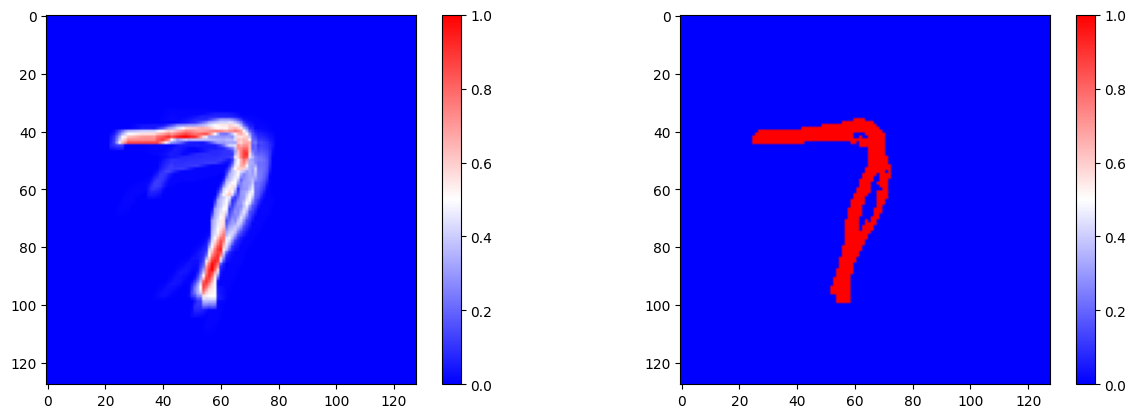

In [1281]:
#w = np.where(weights < np.max(weights) * 0.4, 0, 1) # binarization
w = np.where(weights < 0.3, 0, 1) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
im = ax1.imshow(weights.reshape(config.sample_size, -1), cmap='bwr') # cmap=plt.cm.gray
ax1.figure.colorbar(im, ax=ax1)

im = ax2.imshow(w.reshape(config.sample_size, -1), cmap='bwr') # cmap=plt.cm.gray
ax2.figure.colorbar(im, ax=ax2)

plt.show()

In [1240]:
95 / 100

0.95

In [1254]:
np.histogram(np.round(weights, decimals=2))

(array([15331,   230,   156,   200,   133,   100,    75,    76,    62,
           21]),
 array([0.        , 0.1       , 0.2       , 0.3       , 0.4       ,
        0.5       , 0.6       , 0.7       , 0.8       , 0.90000004,
        1.        ], dtype=float32))

In [1257]:
wfs

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [1270]:
list(zip(wfs, max_coverage_counts))

[(0.05, np.int64(135)),
 (0.1, np.int64(73)),
 (0.15, np.int64(42)),
 (0.2, np.int64(23)),
 (0.25, np.int64(12)),
 (0.3, np.int64(7)),
 (0.35, np.int64(0)),
 (0.4, np.int64(0)),
 (0.45, np.int64(0)),
 (0.5, np.int64(0)),
 (0.55, np.int64(0)),
 (0.6, np.int64(0)),
 (0.65, np.int64(0)),
 (0.7, np.int64(0)),
 (0.75, np.int64(0)),
 (0.8, np.int64(0)),
 (0.85, np.int64(0)),
 (0.9, np.int64(0)),
 (0.95, np.int64(0))]

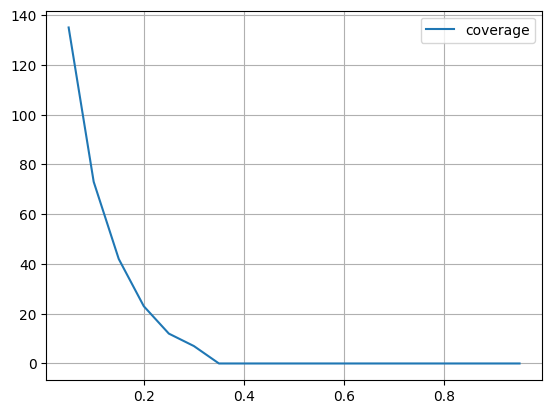

In [1267]:
wfs = []
max_dp_counts = []
max_coverage_counts = []

for wf in range(5, 100, 5):
    wf = wf / 100
    wfs.append(wf)
    # w = np.where(weights < np.max(weights) * wf, 0, 1) 
    w = np.where(weights < wf, 0, 1) 
    
    dp = (w @ bitmap_vecs.T) 
    max_dp = dp.max()
    max_dp_count = (dp >= max_dp).sum()
    max_dp_counts.append(max_dp_count)
    
    max_coverage_counts.append((dp >= np.sum(bitmap_vecs, axis=1).T).sum())

# plt.plot(wfs, max_dp_counts, label='max_dp')
plt.plot(wfs, max_coverage_counts, label='coverage')
# plt.xticks(wfs)
plt.grid()
plt.legend()
plt.show()    

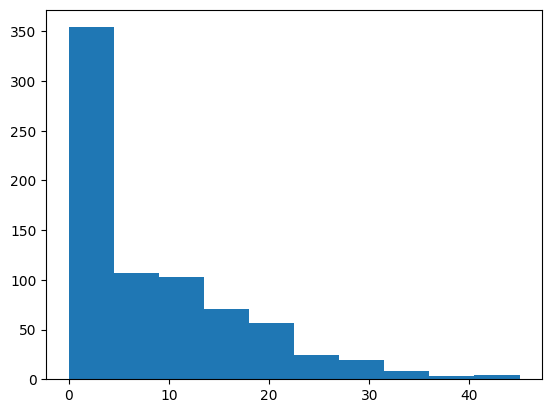

In [1233]:
z = (w @ bitmap_vecs.T)
plt.hist(z)
plt.show()

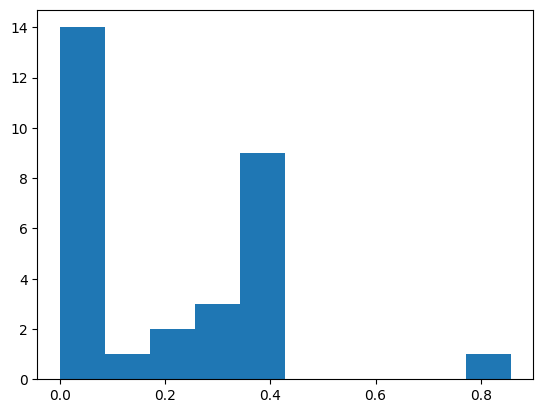

In [1143]:
z = (w @ bitmap_vecs.T) / (w > 0).sum()
plt.hist(z) #, cumulative=True)
plt.show()

seq_lv_ind=82, cos_sim_thres=0.71, engram_id=261, image_id=1600, value=0


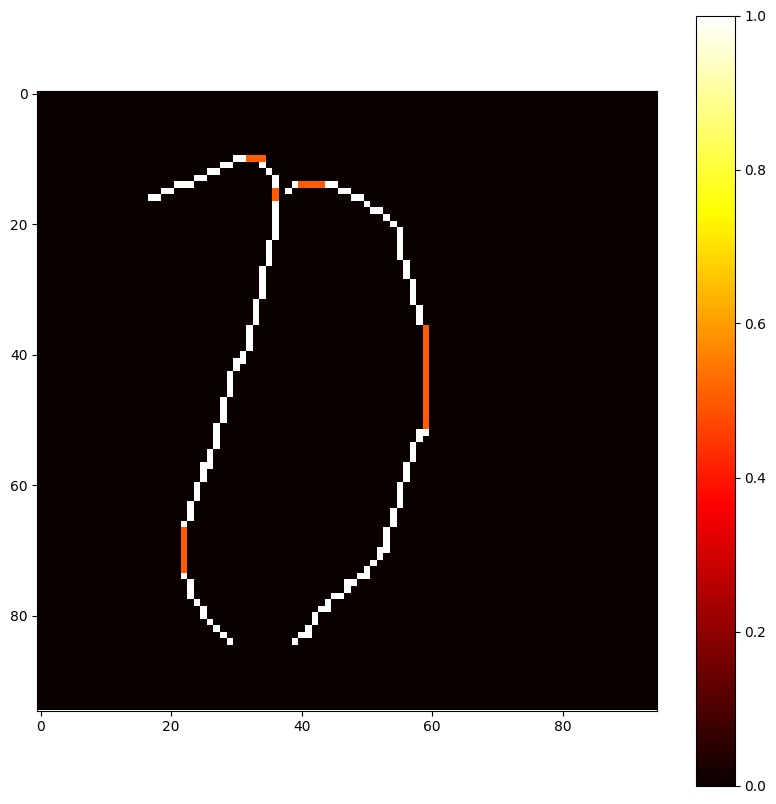

In [79]:
seq_lv_ind = RNG.choice(list(SEQ_LV_IND_TO_META.keys()))
seq_lv_meta = SEQ_LV_IND_TO_META[seq_lv_ind]
engram = ENGRAMS[seq_lv_meta.engram_id]
print(f'seq_lv_ind={seq_lv_ind}, cos_sim_thres={seq_lv_meta.cos_sim_thres:.2f}, engram_id={engram.engram_id}, image_id={engram.image_id}, value={engram.value}')
render_w_vec_heatmap(seq_lv_meta)

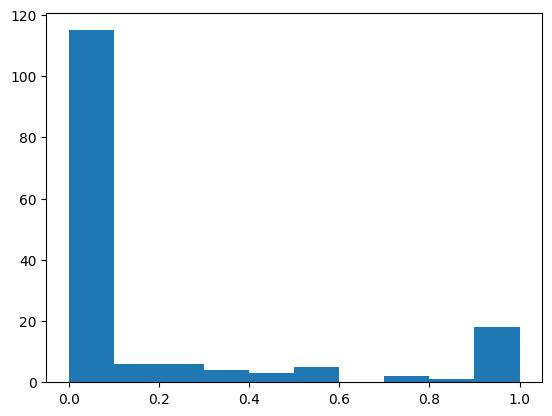

In [69]:
cos_sim_thres_list = list(map(lambda seq_lv_meta: seq_lv_meta.cos_sim_thres, SEQ_LV_IND_TO_META.values()))
neg_pos = list(map(lambda seq_lv_meta: (seq_lv_meta.neg_matches_count, seq_lv_meta.pos_matches_count), SEQ_LV_IND_TO_META.values()))
neg_pos = np.array(neg_pos)
neg_pos_denom = neg_pos.sum(axis=1)
s = neg_pos[:,0] / np.where(neg_pos_denom > 0, neg_pos_denom, 1)
plt.hist(s)
plt.show()

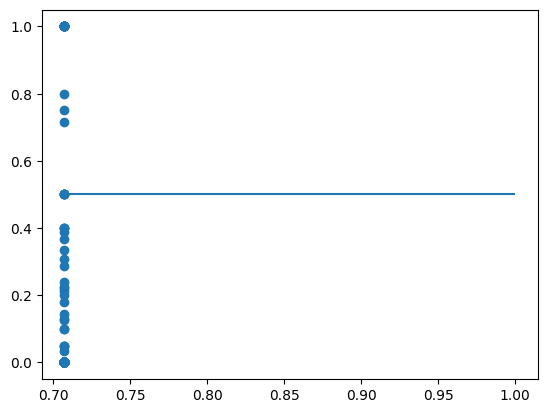

In [70]:
xy = np.array(list(zip(cos_sim_thres_list, s)))
plt.scatter(xy[:,0], xy[:,1])
plt.hlines(0.5, np.min(xy[:,0]), 1)
plt.show()

In [82]:
seq_lv_meta.history

[]

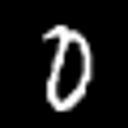

In [81]:
get_raw_image(1600, df_train_images)

In [193]:
df_train_images.loc[54207]

index                                                             1801
value                                                                7
png                  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
outer_si_ind_dict    b'\x80\x04\x95\x079\x00\x00\x00\x00\x00\x00}\x...
inner_si_ind_dict    b'\x80\x04\x95i\x86\x00\x00\x00\x00\x00\x00}\x...
outer_sequences      b'\x80\x04\x95w\x02\x00\x00\x00\x00\x00\x00]\x...
inner_sequences      b'\x80\x04\x95N\x00\x00\x00\x00\x00\x00\x00]\x...
Name: 54207, dtype: object

In [91]:
0.1 * (0.9 ** 4)

0.06561

In [92]:
COS_SIM_45 + 0.034 * 4

np.float64(0.8431067811865476)

In [93]:
1/29

0.034482758620689655

In [106]:
nus = []
updates_counts = []

for seq_lv_ind, seq_lv_meta in SEQ_LV_IND_TO_META.items():
    nus.append(seq_lv_meta.nu)
    updates_counts.append(seq_lv_meta.updates_count)

nus = np.hstack(nus)
updates_counts = np.hstack(updates_counts)
np.histogram(nus), np.histogram(updates_counts)

AttributeError: 'SeqLatentVec' object has no attribute 'updates_count'

In [123]:
list(filter(lambda i_uc: i_uc[1] > 1400, enumerate(updates_counts)))

[(14, np.int64(1479))]

In [125]:
# ENGRAMS[SEQ_LV_IND_TO_META[14].engram_id]

In [75]:
(SEQ_LVS.array_active[3] != 0).sum()

np.int64(553)

In [108]:
seq_lv_ind = 7
w_vec = SEQ_LV_IND_TO_META[seq_lv_ind].w_vec
SEQ_LV_IND_TO_META[seq_lv_ind].updates_count, np.unique_counts(w_vec), w_vec.sum(), np.sqrt(np.sum(w_vec ** 2))

(0,
 UniqueCountsResult(values=array([0., 1.], dtype=float32), counts=array([4056,  444])),
 np.float32(444.0),
 np.float32(21.071308))

In [274]:
seq_lv_updates_history[engram_seq_lv_ind]

[np.int64(7165),
 np.int64(44383),
 np.int64(41772),
 np.int64(8715),
 np.int64(27422),
 np.int64(5857),
 np.int64(27375),
 np.int64(15579),
 np.int64(46153),
 np.int64(2248),
 np.int64(23565),
 np.int64(11484),
 np.int64(30149),
 np.int64(45797),
 np.int64(58604),
 np.int64(4168),
 np.int64(46149),
 np.int64(38608),
 np.int64(53024),
 np.int64(8715),
 np.int64(23565),
 np.int64(30149),
 np.int64(8715),
 np.int64(23565),
 np.int64(30149),
 np.int64(8715),
 np.int64(23565),
 np.int64(30149),
 np.int64(8715)]

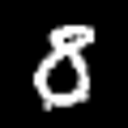

In [162]:
# %%time
image_id = RNG.choice(df_train_images.index)
image_id = 30149
image = Image.open(io.BytesIO(df_train_images.loc[image_id]['png']))
image

In [111]:
cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T

In [45]:
matchee = create_matchee(df_train_images.loc[image_id])

In [57]:
xp_array_from_gpu(cos_sim_mat[i,j])

array(0.52802728)

In [60]:
xp.take(cos_sim_ma, top_mat_indices)

array([0.52802728, 0.52805699, 0.52852144, 0.52870091, 0.5288168 ,
       0.52899192, 0.52904237, 0.52910437, 0.5291858 , 0.52921132,
       0.52932992, 0.52981349, 0.52987864, 0.5298983 , 0.53001637,
       0.53091887, 0.53181364, 0.53184084, 0.53200186, 0.53210089,
       0.53222864, 0.53257177, 0.5333655 , 0.53353145, 0.5341961 ,
       0.53454791, 0.53501479, 0.53565665, 0.53640483, 0.53650111,
       0.53715824, 0.53774765, 0.53831506, 0.53844076, 0.53849261,
       0.53886665, 0.53924699, 0.53941241, 0.53971616, 0.53995301,
       0.54011405, 0.54018985, 0.54027345, 0.54049893, 0.54050326,
       0.54052553, 0.54053141, 0.54081165, 0.54082106, 0.54088954,
       0.54119227, 0.54148538, 0.54150746, 0.54151672, 0.54168996,
       0.54189594, 0.54219426, 0.54231309, 0.54250883, 0.54259895,
       0.54268381, 0.54277117, 0.54289654, 0.54373794, 0.54374626,
       0.54377325, 0.54378835, 0.54380495, 0.54387874, 0.54398342,
       0.54403525, 0.5441069 , 0.5442786 , 0.54442379, 0.54472

In [61]:
a1 = np.arange(9).reshape(3, 3)
a1

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [69]:
a1.ravel()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [71]:
np.flip(a1.ravel())

array([8, 7, 6, 5, 4, 3, 2, 1, 0])

In [68]:
type(top_mat_indices)

numpy.ndarray

In [72]:
%%time
inspect_depth = 100

match_tab_columns = defaultdict(list)
cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
top_mat_indices = np.flip(top_mat_indices)
cos_sim_values = np.flip(cos_sim_values)

for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
    i = top_mat_index // cos_sim_mat.shape[1]
    j = top_mat_index % cos_sim_mat.shape[1]
    seq_lv_meta = SEQ_LV_IND_TO_META[i]
    engram = ENGRAMS[seq_lv_meta.engram_id]
    match_tab_columns['engram_seq_lv_ind'].append(i)
    match_tab_columns['matchee_seq_lv_ind'].append(j)
    match_tab_columns['cos_sim'].append(cos_sim_value)
    match_tab_columns['engram_id'].append(engram.engram_id)
    match_tab_columns['engram_value'].append(engram.value)
    match_tab_columns['engram_image_id'].append(engram.image_id)  
    match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
    match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
    match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])

df_match_tab = pd.DataFrame(match_tab_columns)
df_match_tab.head(10)

CPU times: user 8.3 ms, sys: 13.1 ms, total: 21.4 ms
Wall time: 19.4 ms


,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code
0,33,813,0.560668,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 1))"
1,33,812,0.559649,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 0))"
2,33,815,0.555197,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 1), (3, 1))"
3,33,814,0.554326,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 1), (3, 0))"
4,37,2614,0.552823,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((3, 1), (1, 0), (2, 1), (4, 1), (0, 0))"
5,37,2612,0.552823,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((3, 1), (1, 0), (2, 1), (4, 0), (0, 0))"
6,33,3149,0.552264,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((4, 0), (0, 1), (2, 1), (1, 0), (3, 1))"
7,33,3148,0.550657,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((4, 0), (0, 1), (2, 1), (1, 0), (3, 0))"
8,37,813,0.550207,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 1))"
9,2,1005,0.550045,1,4,26704,0,"((0, 0), (1, 1), (2, 0))","((1, 0), (2, 1), (0, 1), (4, 0), (3, 1))"


# Test

In [120]:
count = 200
get_test_image_ids = lambda df: RNG.choice(df.index.unique(), min(count, len(df)), replace=False)
TestRunSource = namedtuple('TestRunSource', ['df_images', 'db_con', 'source_ds', 'test_image_ids'])
test_run_source = {
    'test': TestRunSource(df_test_images, test_db_con, 'test', get_test_image_ids(df_test_images)),
    'train': TestRunSource(df_train_images, train_db_con, 'train', get_test_image_ids(df_train_images)),
    'train2': TestRunSource(df_train_images, train_db_con, 'train2', train_image_ids)
}['test']

In [121]:
%%time
test_results_db_con.cursor().execute('INSERT INTO test_runs(dummy) VALUES(1)')
test_results_db_con.commit()
test_run_id = test_results_db_con.cursor().execute('SELECT MAX(test_run_id) FROM test_runs').fetchone()[0]
test_result_rows = defaultdict(list)
match_tabs_raw = []
match_tabs = []

for image_id in tqdm(test_run_source.test_image_ids):
    df_image = test_run_source.df_images.loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee_cached(df_image)
    
    df_match_tab_raw = get_match_tab(matchee) #, inspect_depth=1000)
    df_match_tab_raw['test_image_id'] = image_id
    df_match_tab_raw['true_value'] = image_value
    match_tabs_raw.append(df_match_tab_raw)
    
    df_match_tab = df_match_tab_raw[df_match_tab_raw['is_match'] == True] if len(df_match_tab_raw) > 0 else df_match_tab_raw
    match_tabs.append(df_match_tab)
    
    infer_value, engram_image_id, cos_sim = ('', -1, 0)
        
    if len(df_match_tab) > 0:
        infer_value, engram_image_id, cos_sim = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim']]
    
    test_result_rows['test_run_id'].append(test_run_id)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['notebook_fname'].append(notebook_fname)
    test_result_rows['cortical_columns'].append(f'[{','.join([])}]')
    test_result_rows['train_images_count'].append(TRAIN_IMAGES_COUNT)
    test_result_rows['train_runs_count'].append(TRAIN_RUNS_COUNT)
    test_result_rows['source_ds'].append(test_run_source.source_ds)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(engram_image_id)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['cos_sim'].append(cos_sim)
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    test_result_rows['engrams_count'].append(len(ENGRAMS))

df_test_results_for_run = pd.DataFrame(test_result_rows)
df_test_results_for_run['timestamp'] = datetime.datetime.now()

if DBUtils.is_table_exists(test_results_db_con, 'test_results'):
    DBUtils.ensure_table_columns(test_results_db_con, 'test_results', list(df_test_results_for_run.columns))
    
df_test_results_for_run.to_sql(name='test_results', con=test_results_db_con, if_exists='append')
pd.DataFrame({'test_run_id': [test_run_id], 'match_tabs': [pickle.dumps(match_tabs)]}).to_sql(name='test_run_artifacts', con=test_results_db_con, if_exists='append');

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 1min 16s, sys: 2.41 s, total: 1min 18s
Wall time: 12.4 s


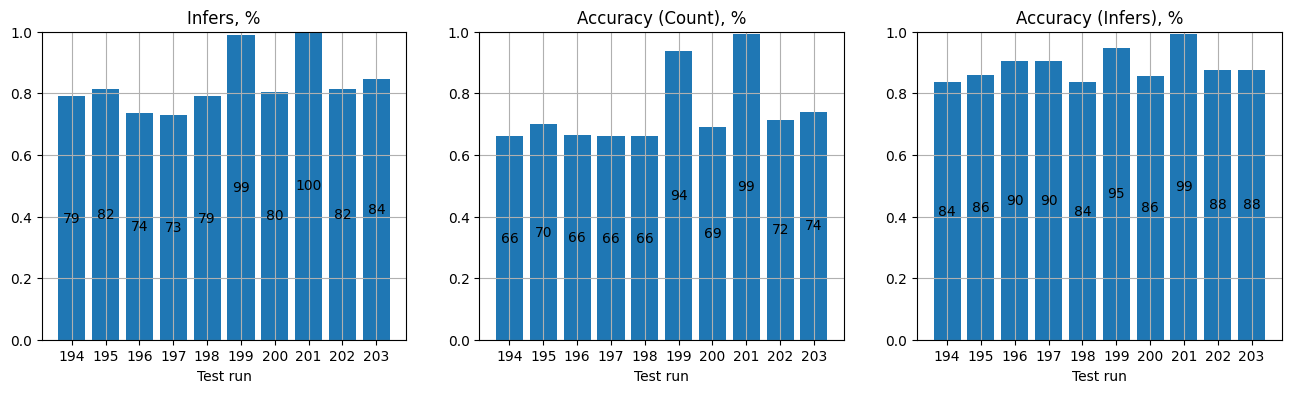

,timestamp,source_ds,train_images_count,engrams_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,
194,2025-05-26 13:58:30.952440,test,729,173,200,158,132,0.790,0.660,0.835443
195,2025-05-26 14:00:05.445578,test,633,170,200,163,140,0.815,0.700,0.858896
196,2025-05-26 14:03:41.462337,test,575,194,200,147,133,0.735,0.665,0.904762
197,2025-05-26 14:04:36.219424,test,598,199,200,146,132,0.730,0.660,0.904110
198,2025-05-26 14:06:02.170398,test,729,173,200,158,132,0.790,0.660,0.835443
199,2025-05-26 14:10:40.659687,train2,5000,209,500,495,469,0.990,0.938,0.947475
200,2025-05-26 14:11:07.627946,test,5000,209,200,161,138,0.805,0.690,0.857143
201,2025-05-26 14:16:06.499830,train2,2669,213,500,500,497,1.000,0.994,0.994000
202,2025-05-26 14:16:39.014413,test,2669,213,200,163,143,0.815,0.715,0.877301


In [122]:
df_test_results2 = pd.read_sql_query('''
SELECT * FROM test_results 
WHERE test_run_id IN (SELECT test_run_id FROM test_runs ORDER BY test_run_id DESC LIMIT 10) 
ORDER BY test_run_id ASC
''', con=test_results_db_con)
df_test_results2['test_run_id'] = df_test_results2['test_run_id'].astype(int)
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'timestamp': 'first',
                                                                     'config_variant': 'first', 
                                                                     'notebook_fname': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'engrams_count': 'first',
                                                                     'train_runs_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.sort_values(by=['test_run_id'], inplace=True)
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2[['timestamp', 'notebook_fname', 'source_ds', 'train_images_count', 'engrams_count', 'count', 'infers', 'correct_infers', 'infer_ratio', 'accuracy_count', 'accuracy_infers']]

## analyze

In [114]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index']]
df_incorrect.head(10)

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index
3,51119,40216,2,7,0.823126,3
8,18149,-1,6,,0.000000,8
10,32636,-1,8,,0.000000,10
20,9600,-1,2,,0.000000,20
21,37307,-1,2,,0.000000,21
22,3397,-1,3,,0.000000,22
24,31620,-1,6,,0.000000,24
35,38494,-1,0,,0.000000,35
43,15883,-1,0,,0.000000,43
44,22962,-1,6,,0.000000,44


In [171]:
# df_correct = df_test_results_for_run.loc[df_test_results_for_run.true_value == df_test_results_for_run.infer_value].copy()
# df_correct = df_correct[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index']]
# df_correct.head(10)

In [115]:
match_tab_index = 3
match_tab = match_tabs_raw[match_tab_index]
# match_tab = match_tabs[match_tab_index]
column_names = ['test_image_id', 'true_value', 'engram_value', 'cos_sim', 'cos_sim_thres', 'is_match',
                'engram_id', 'engram_image_id', 'engram_seq_reading', 'engram_seq_lv_ind',
                'matchee_seq_reading', 'matchee_seq_lv_ind']
match_tab.head(10)[column_names]

,test_image_id,true_value,engram_value,cos_sim,cos_sim_thres,is_match,engram_id,engram_image_id,engram_seq_reading,engram_seq_lv_ind,matchee_seq_reading,matchee_seq_lv_ind
0,51119,2,7,0.823126,0.796604,True,1091,40216,"((0, 0), (1, 0))",16,"((1, 1), (0, 0))",6
1,51119,2,2,0.795236,0.793449,True,939,42373,"((0, 0), (1, 0))",14,"((1, 1), (0, 0))",6
2,51119,2,2,0.762130,0.714774,True,950,52118,"((0, 0), (1, 0))",25,"((1, 1), (0, 0))",6
3,51119,2,7,0.718115,0.749510,False,934,50278,"((0, 0),)",9,"((1, 0), (0, 0))",4
4,51119,2,7,0.664381,0.809533,False,957,52181,"((0, 0), (1, 0), (2, 0))",32,"((0, 0), (1, 1))",1
5,51119,2,7,0.653490,0.749510,False,934,50278,"((0, 0),)",9,"((1, 0), (0, 1))",5
6,51119,2,7,0.633185,0.809533,False,957,52181,"((0, 0), (1, 0), (2, 0))",32,"((1, 1), (0, 0))",6
7,51119,2,0,0.630794,0.827758,False,1073,30149,"((0, 0), (1, 0))",148,"((1, 1), (0, 0))",6
8,51119,2,2,0.628200,0.762454,False,1031,35235,"((0, 0), (1, 0))",106,"((0, 0), (1, 1))",1
9,51119,2,6,0.627848,0.854428,False,1093,48471,"((0, 0), (1, 0))",19,"((1, 1), (0, 0))",6


In [116]:
# get_raw_image(41464, df_train_images)

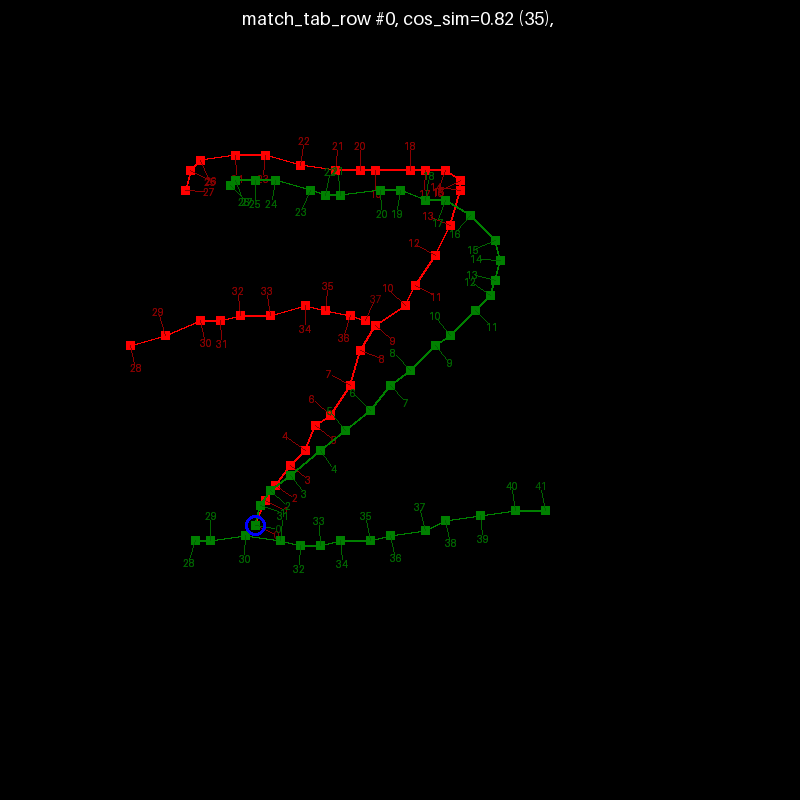

In [117]:
df_match_tab_row = match_tab.iloc[0]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_reading'])
# matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv_meta = SEQ_LV_IND_TO_META[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv_orig = df_match_tab_row['engram_seq_lv_orig']

matchee_seq_reading = df_match_tab_row['matchee_seq_reading']
matchee_seq_lv_ind = matchee.seq_readings.index(matchee_seq_reading)
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv_orig = matchee.seq_lvs_orig[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy = np.array([10, 10]), k=5)

In [80]:
(engram_seq_lv_orig @ matchee_seq_lv_orig) / (np.linalg.norm(engram_seq_lv_orig) * np.linalg.norm(matchee_seq_lv_orig))

np.float32(0.8304997)

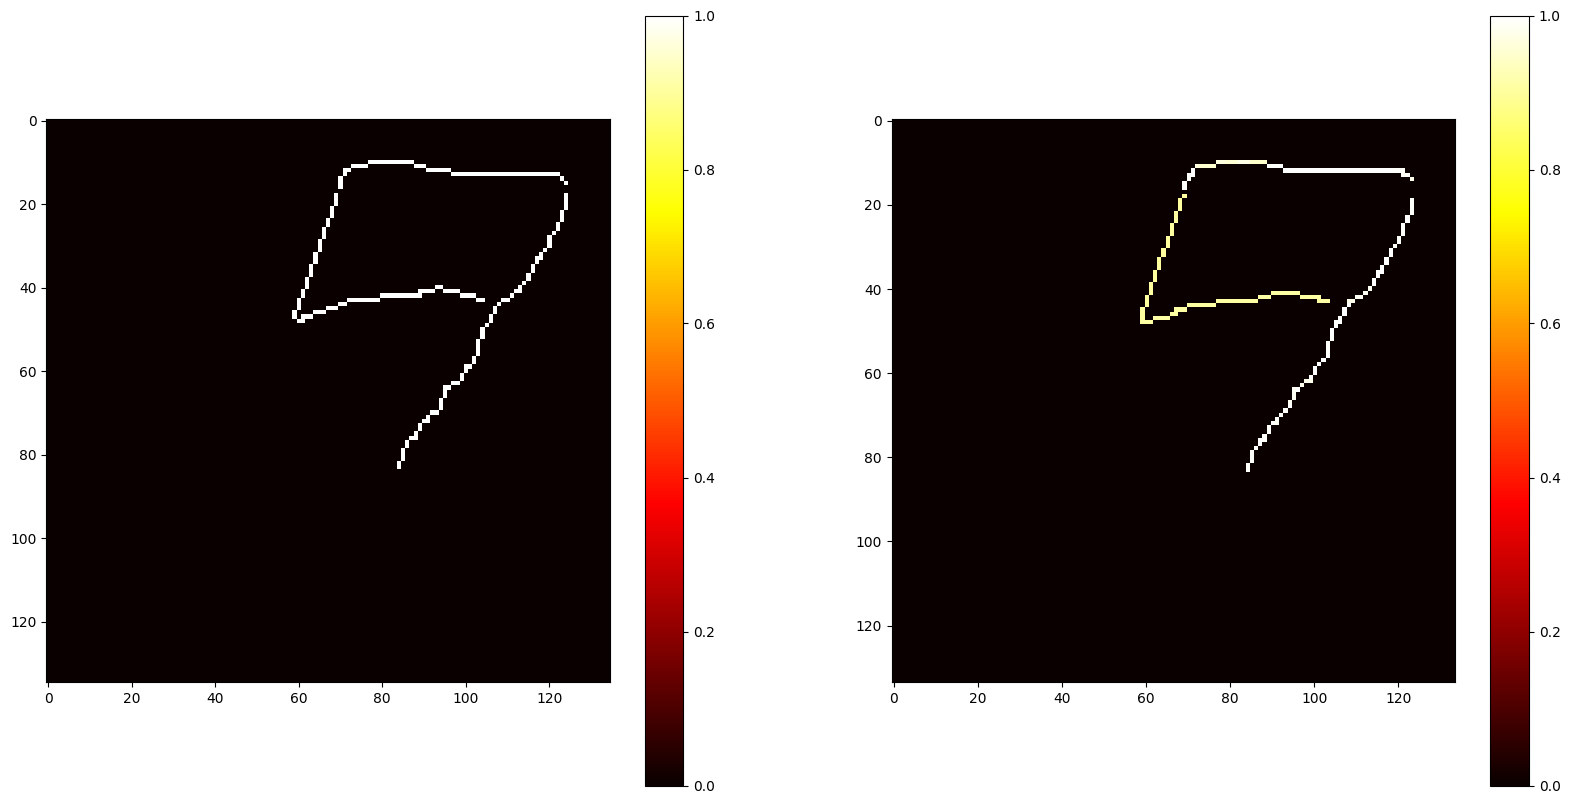

In [118]:
render_seq_lv_orig_upd(engram_seq_lv_meta)

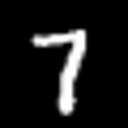

In [93]:
get_raw_image(57196, df_train_images)

In [82]:
engram_seq_lv_meta.cos_sim_thres

0.7133076202869415

In [81]:
engram_seq_lv_meta.seq_lv_ind

84

In [94]:
ENGRAMS[engram_seq_lv_meta.engram_id].image_id

168

In [133]:
engram_seq_lv_meta.pos_matches_count

1

In [120]:
engram_seq_lv_meta.history

{50923: SeqLatentVecHistoryItem(image_id=np.int64(50923), cos_sim=0.7722010612487793, is_correct_match=True),
 np.int64(683): SeqLatentVecHistoryItem(image_id=np.int64(683), cos_sim=0.7362493276596069, is_correct_match=True),
 np.int64(59140): SeqLatentVecHistoryItem(image_id=np.int64(59140), cos_sim=0.7473859190940857, is_correct_match=True),
 np.int64(43408): SeqLatentVecHistoryItem(image_id=np.int64(43408), cos_sim=0.7221878170967102, is_correct_match=True),
 np.int64(24425): SeqLatentVecHistoryItem(image_id=np.int64(24425), cos_sim=0.7845925092697144, is_correct_match=False),
 np.int64(56451): SeqLatentVecHistoryItem(image_id=np.int64(56451), cos_sim=0.7184270620346069, is_correct_match=True),
 np.int64(44500): SeqLatentVecHistoryItem(image_id=np.int64(44500), cos_sim=0.7165065407752991, is_correct_match=True),
 np.int64(56795): SeqLatentVecHistoryItem(image_id=np.int64(56795), cos_sim=0.7697305679321289, is_correct_match=False),
 np.int64(3304): SeqLatentVecHistoryItem(image_id=np

In [143]:
np.histogram(get_w_vec(engram_seq_lv_meta))

(array([4072,    0,   58,  136,   23,   33,   29,   56,   70,   23]),
 array([0.        , 0.1       , 0.2       , 0.3       , 0.4       ,
        0.5       , 0.6       , 0.7       , 0.8       , 0.90000004,
        1.        ], dtype=float32))

In [156]:
sublv_indices = slice(1, 2)
indices2 = slice(0, 150)
# indices2 = slice(150, -1)
# indices2 = slice(0, -1)
engram_seq_sublv = engram_seq_lv_orig.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2]
matchee_seq_sublv = matchee_seq_lv_orig.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2]
(engram_seq_sublv @ matchee_seq_sublv) / (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))

np.float32(0.6617729)

In [157]:
engram_seq_sublv

array([-0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394,  0.        ,  0.        ,  0.        ,  0.  

In [164]:
engram_seq_sublv = engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2] 
matchee_seq_sublv = matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2]
(engram_seq_sublv @ matchee_seq_sublv) / (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))

np.float32(0.66177285)

In [165]:
engram_seq_sublv

array([-0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646,  0.        ,  0.        ,  0.        ,  0.  

In [254]:
engram_seq_sublv = (engram_seq_lv_orig * engram_seq_lv_meta.w_vec).reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()
# matchee_seq_sublv = (matchee_seq_lv_orig * engram_seq_lv_meta.w_vec).reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()
matchee_seq_sublv = (matchee_seq_lv_orig).reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()
(engram_seq_sublv @ matchee_seq_sublv) / (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))

np.float32(0.7419082)

In [249]:
np.linalg.norm(engram_seq_sublv), \
np.linalg.norm(matchee_seq_sublv), \
engram_seq_sublv @ matchee_seq_sublv, \
np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv), \
(engram_seq_sublv != 0).sum(), (matchee_seq_sublv != 0).sum(), 

(np.float32(11.113664),
 np.float32(14.933185),
 np.float32(142.9913),
 np.float32(165.96239),
 np.int64(401),
 np.int64(421))

In [255]:
np.linalg.norm(engram_seq_sublv), \
np.linalg.norm(matchee_seq_sublv), \
engram_seq_sublv @ matchee_seq_sublv, \
np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv), \
(engram_seq_sublv != 0).sum(), (matchee_seq_sublv != 0).sum(), 

(np.float32(11.523941),
 np.float32(14.933185),
 np.float32(127.67435),
 np.float32(172.08914),
 np.int64(376),
 np.int64(421))

In [ ]:
np.histogram(engram_seq_lv_meta.w_vec)

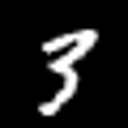

In [213]:
Image.open(io.BytesIO(df_test_images.loc[100003769]['png']))

In [175]:
list(map(lambda kv: kv[1].image_id, filter(lambda kv: kv[1].value == '6', ENGRAMS.items())))

[25959, 46074, 39577, 27536, 39777, 5654]

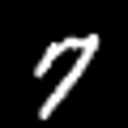

In [212]:
Image.open(io.BytesIO(df_train_images.loc[53171]['png']))

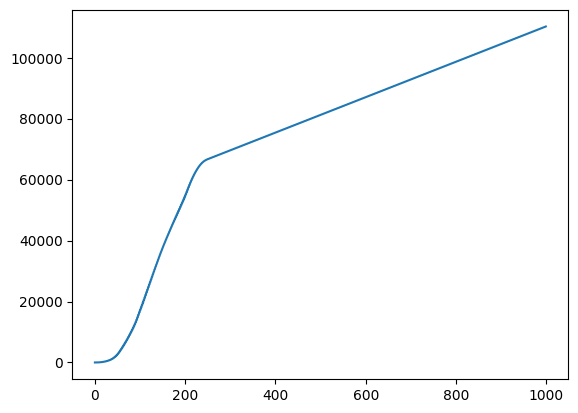

In [128]:
seq_lvs_diff = 0
seq_lvs_diff_cums = []

for vec1, vec2 in zip(engram_seq_lv[:1000], matchee_seq_lv[:1000]):
    vec = vec1 - vec2
    vec = vec ** 2
    seq_lvs_diff += vec.sum()
    seq_lvs_diff_cums.append(seq_lvs_diff)

seq_lvs_diff

plt.plot(seq_lvs_diff_cums)
plt.show()

In [130]:
matchee = create_matchee(df_test_image)
mt = get_match_tab(matchee, inspect_depth=9999999)
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((1,0), (2,0), (3,0), (0,0)))]
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((0,0), (1,0)))]
# mt[(mt['matchee_seq_lv_code'] == ((1,0), (0,0)))]
mt[(mt['engram_image_id'] == 5654)]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code
3718,14157,4,-1,1.065956e+06,46,6,5654,0,"((0, 1), (1, 1))","((1, 0), (0, 0))"
3719,14161,0,-1,1.065956e+06,46,6,5654,0,"((1, 1), (0, 1))","((0, 0), (1, 0))"
3720,14155,6,-1,1.080466e+06,46,6,5654,0,"((0, 0), (1, 1))","((1, 1), (0, 0))"
3721,14160,1,-1,1.080466e+06,46,6,5654,0,"((1, 1), (0, 0))","((0, 0), (1, 1))"
3792,14157,6,-1,1.134638e+06,46,6,5654,0,"((0, 1), (1, 1))","((1, 1), (0, 0))"
...,...,...,...,...,...,...,...,...,...,...
116653,14158,1,-1,7.748395e+06,46,6,5654,0,"((1, 0), (0, 0))","((0, 0), (1, 1))"
116706,14156,6,-1,7.807281e+06,46,6,5654,0,"((0, 1), (1, 0))","((1, 1), (0, 0))"
116707,14159,1,-1,7.807281e+06,46,6,5654,0,"((1, 0), (0, 1))","((0, 0), (1, 1))"
116709,14154,4,-1,7.808612e+06,46,6,5654,0,"((0, 0), (1, 0))","((1, 0), (0, 0))"


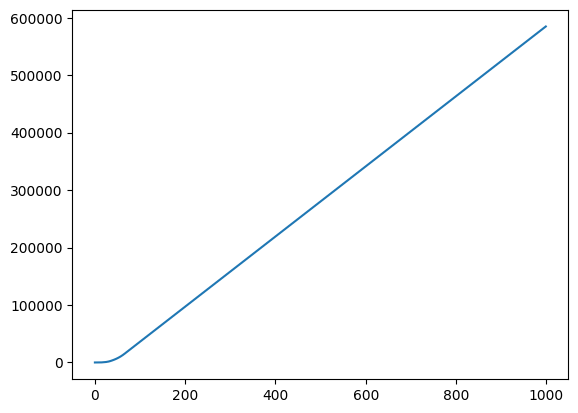

In [131]:
df_match_tab_row = mt.iloc[3718]
engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]

seq_lvs_diff = 0
seq_lvs_diff_cums = []

for vec1, vec2 in zip(engram_seq_lv[:1000], matchee_seq_lv[:1000]):
    vec = vec1 - vec2
    vec = vec ** 2
    seq_lvs_diff += vec.sum()
    seq_lvs_diff_cums.append(seq_lvs_diff)

seq_lvs_diff

plt.plot(seq_lvs_diff_cums)
plt.show()

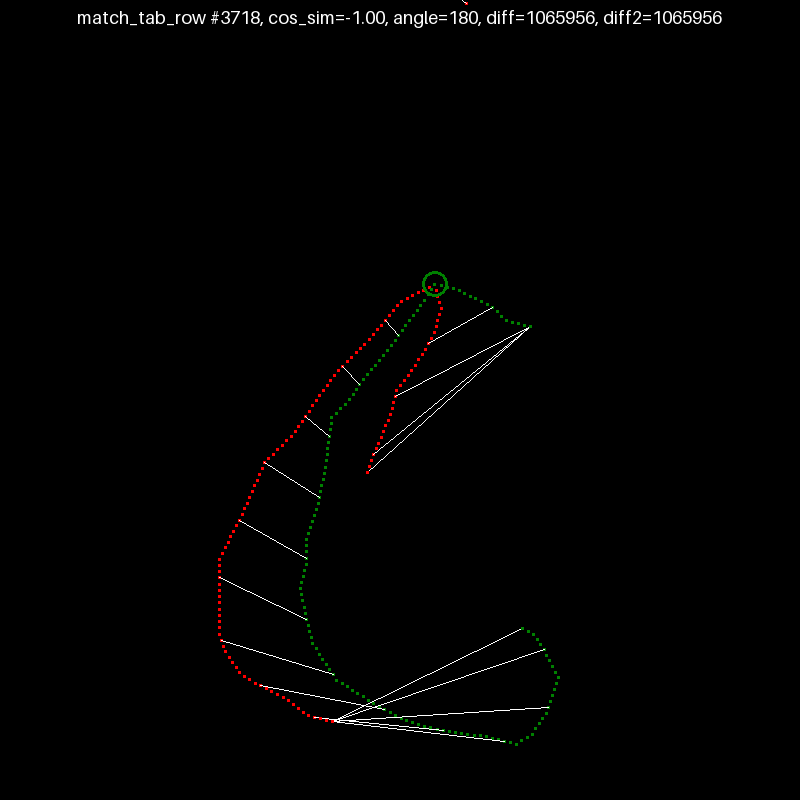

In [132]:
render_match_tab_row(mt.iloc[3718], matchee, use_seq_lv=True) # 1324

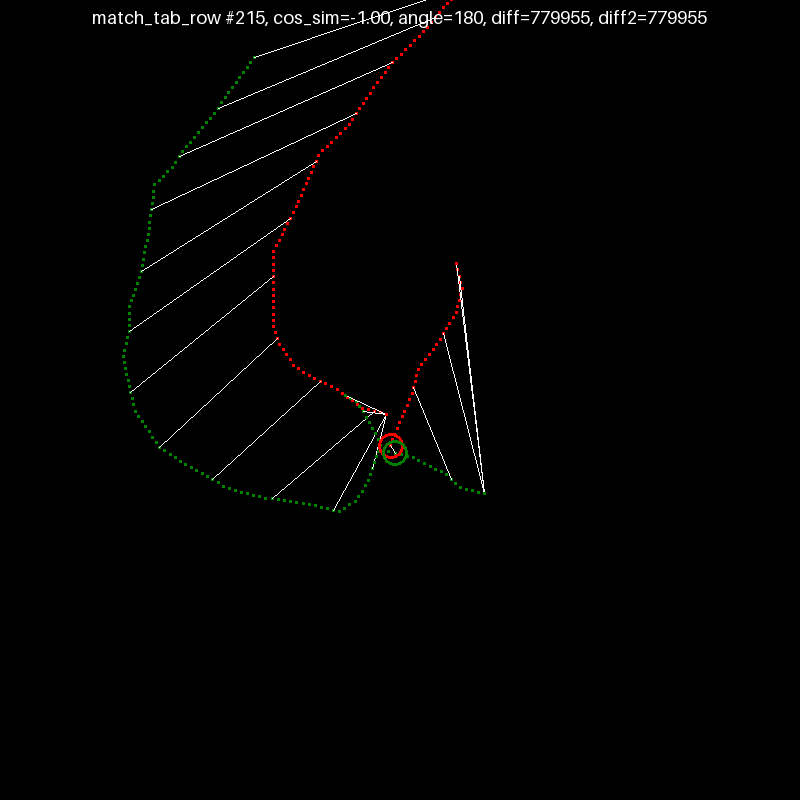

In [306]:
render_match_tab_row(mt.iloc[215], matchee, use_seq_lv=True) # 1324

## xxx

In [203]:
# df_test_results_for_run_c = df_test_results_for_run.copy()

In [204]:
test_run_id_c = int(df_test_results_for_run_c['test_run_id'][0])
match_tabs_c = pickle.loads(pd.read_sql(f'SELECT match_tabs FROM test_run_artifacts WHERE test_run_id = {test_run_id_c}', con=test_results_db_con).iloc[0]['match_tabs'])

In [206]:
df_incorrect_c = df_test_results_for_run_c.loc[df_test_results_for_run_c.true_value != df_test_results_for_run_c.infer_value]
df_incorrect_c = df_incorrect_c[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_correct_c = df_test_results_for_run_c.loc[df_test_results_for_run_c.true_value == df_test_results_for_run_c.infer_value].copy()
df_correct_c = df_correct_c[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_incorrect_c.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
0,100003752,29437,4,6,0.841084,0,cos_sim
1,100001264,9758,4,9,0.893869,1,cos_sim
7,100009710,44106,6,5,0.807008,7,cos_sim
21,100001178,1033,4,2,0.788638,21,cos_sim
38,100001012,9484,7,2,0.821328,38,cos_sim


In [207]:
df_correct_c.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
2,100005629,38800,2,2,0.776715,2,cos_sim
3,100007696,56698,4,4,0.876949,3,cos_sim
4,100000111,43598,7,7,0.907990,4,cos_sim
5,100001435,42773,9,9,0.756153,5,cos_sim
6,100007232,15507,1,1,0.875834,6,cos_sim


In [257]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_incorrect.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
8,100007903,3924,7,2,0.773791,8,cos_sim
12,100004207,29437,8,6,0.734214,12,cos_sim
18,100008928,6448,9,4,0.733242,18,cos_sim
20,100007613,42349,6,0,0.774789,20,cos_sim
37,100001012,57752,7,2,0.768041,37,cos_sim


In [258]:
set(df_incorrect['test_image_id']) - set(df_incorrect_c['test_image_id'])#, set(df_incorrect_c['test_image_id']) - set(df_incorrect['test_image_id'])

{100000900,
 100001017,
 100001099,
 100003279,
 100003728,
 100004015,
 100006248,
 100006294,
 100006833,
 100006850,
 100006972,
 100007613,
 100007747,
 100008495}

In [259]:
df_incorrect[df_incorrect['test_image_id'] == 100000900]

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
63,100000900,50564,1,4,0.835808,63,cos_sim


In [260]:
df_correct_c[df_correct_c['test_image_id'] == 100000900]

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
145,100000900,15730,1,1,0.857304,145,cos_sim


In [218]:
# list(filter(lambda kv: kv[1].image_id == 15730,  ENGRAMS.items()))

In [261]:
mt = match_tabs[63]
mt[mt['engram_image_id'] == 15730]
# mt

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
2,2418,24,0.820190,3086,1,15730,0,"((1, 0), (2, 0), (0, 0))","((1, 0), (2, 0), (0, 0))",100000900,1
3,2417,16,0.795339,3086,1,15730,0,"((1, 0), (0, 0), (2, 0))","((1, 0), (0, 0), (2, 0))",100000900,1
4,2415,0,0.783616,3086,1,15730,0,"((0, 0), (1, 0), (2, 0))","((0, 0), (1, 0), (2, 0))",100000900,1
5,2420,40,0.781336,3086,1,15730,0,"((2, 0), (1, 0), (0, 0))","((2, 0), (1, 0), (0, 0))",100000900,1
7,2419,32,0.764612,3086,1,15730,0,"((2, 0), (0, 0), (1, 0))","((2, 0), (0, 0), (1, 0))",100000900,1
46,2420,24,0.697691,3086,1,15730,0,"((2, 0), (1, 0), (0, 0))","((1, 0), (2, 0), (0, 0))",100000900,1
48,2417,32,0.696572,3086,1,15730,0,"((1, 0), (0, 0), (2, 0))","((2, 0), (0, 0), (1, 0))",100000900,1
58,2419,16,0.684397,3086,1,15730,0,"((2, 0), (0, 0), (1, 0))","((1, 0), (0, 0), (2, 0))",100000900,1
76,2416,8,0.676281,3086,1,15730,0,"((0, 0), (2, 0), (1, 0))","((0, 0), (2, 0), (1, 0))",100000900,1
99,2416,0,0.659447,3086,1,15730,0,"((0, 0), (2, 0), (1, 0))","((0, 0), (1, 0), (2, 0))",100000900,1


In [262]:
match_tabs_c[145]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
0,56975,33,0.857304,2577,1,15730,0,"((2, 0), (0, 0), (1, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
1,56977,35,0.845943,2577,1,15730,0,"((2, 0), (0, 1), (1, 1))","((2, 0), (0, 1), (1, 1))",100000900,1
2,56957,15,0.844402,2577,1,15730,0,"((0, 1), (2, 1), (1, 1))","((0, 1), (2, 1), (1, 1))",100000900,1
3,56961,19,0.837876,2577,1,15730,0,"((1, 0), (0, 1), (2, 1))","((1, 0), (0, 1), (2, 1))",100000900,1
4,56532,0,0.835808,2572,4,50564,0,"((2, 0), (1, 0), (0, 0))","((0, 0), (1, 0), (2, 0))",100000900,1
...,...,...,...,...,...,...,...,...,...,...,...
95,29075,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (4, 0), (2, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
96,29045,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (2, 1), (4, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
97,29044,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (2, 1), (4, 0))","((2, 0), (0, 0), (1, 1))",100000900,1
98,28627,7,0.743371,2524,1,57931,0,"((1, 1), (0, 1), (2, 1))","((0, 1), (1, 1), (2, 1))",100000900,1


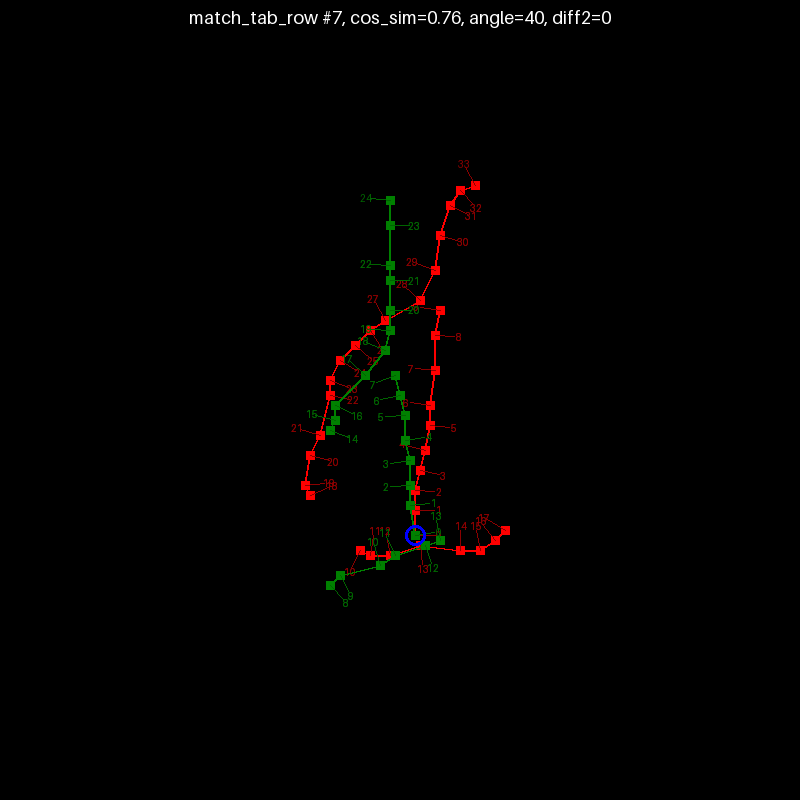

In [264]:
match_tab = match_tabs[63]
df_match_tab_row = match_tab.iloc[7]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_lv_code'])
# matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
# engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv2 = SEQ_LVS2.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
# matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv2 = matchee.seq_lvs2[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy = np.array([10, 15]), k=5)

In [246]:
seq_sublv_i = 0
engram_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)].ravel() @ matchee_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)].ravel()

np.float32(30.74998)

In [251]:
engram_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)][100:]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [245]:
matchee_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)][:50]

array([[-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,